In [385]:
import numpy as np
import yaml
import os
from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 

from utils.load_datasets import load_dataset
from models import vgg
from models.cvae import CVAE
from models.vgg_vmmix import BiternionVGGMixture

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [191]:
dataset_name = "CAVIAR-o" #"IDIAP" #"CAVIAR-o"
dataset_path = 'data/CAVIAR-o.pkl.gz' #'data//IDIAP.pkl' #'data/CAVIAR-o.pkl.gz' #
net_output = 'pan'
model_type = 'cvae'

In [150]:
(xtr, ytr_bit, ytr_deg), (xval, yval_bit, yval_deg), (xte, yte_bit, yte_deg) = load_dataset(dataset_name,
                                                                                            dataset_path,
                                                                                            net_output)

image_height, image_width, n_channels = xtr.shape[1], xtr.shape[2], xtr.shape[3]

In [409]:
if dataset_name=='CAVIAR-o':
    pretrained_path = 'pretrained_models/CAVIAR-o'

vggbit_cosine_config_path = os.path.join(pretrained_path, 'cosine/model.best.params.yml')
vggbit_cosine_weights_path = os.path.join(pretrained_path, 'cosine/model.best.weights.hdf5')
vggbit_likelihood_config_path = os.path.join(pretrained_path, 'likelihood/model.best.params.yml')
vggbit_likelihood_weights_path =  os.path.join(pretrained_path, 'likelihood/model.best.weights.hdf5')
vmmix_config_path =  os.path.join(pretrained_path, 'vm_mixture/model.best.params.yml')
vmmix_weights_path =  os.path.join(pretrained_path, 'vm_mixture/model.best.weights.hdf5')
cvae_config_path =  os.path.join(pretrained_path, 'cvae/model.best.params.yml')
cvae_weights_path =  os.path.join(pretrained_path, 'cvae/model.best.weights.hdf5')

In [410]:
def load_config(net_config_path):
    with open(net_config_path, 'r') as f:
        net_config = yaml.load(f)
    return net_config

vggbit_cosine_model = vgg.BiternionVGG(image_height=image_height,
                                image_width=image_width,
                                n_channels=3,
                                predict_kappa=False,
                                loss_type='cosine',
                                **load_config(vggbit_cosine_config_path))
vggbit_cosine_model.load_weights(vggbit_cosine_weights_path)
_ = vggbit_cosine_model.finetune_kappa(xval, yval_bit, max_kappa=1000)

vggbit_likelihood_model = vgg.BiternionVGG(image_height=image_height,
                                image_width=image_width,
                                n_channels=3,
                                predict_kappa=True,
                                loss_type='vm_likelihood',
                                **load_config(vggbit_likelihood_config_path))
vggbit_likelihood_model.load_weights(vggbit_likelihood_weights_path)

vmmix_model = BiternionVGGMixture(image_height=image_height,
                            image_width=image_width,
                            n_channels=3,
                            **load_config(vmmix_config_path))

vmmix_model.load_weights(vmmix_weights_path)
    
cvae_model = CVAE(image_height=image_height,
                 image_width=image_width,
                 n_channels=n_channels,
                 **load_config(cvae_config_path))

cvae_model.load_weights(cvae_weights_path)

using cosine loss..
using likelihood loss..


In [412]:
starting_frame = 0
n_frames = 50
frames = np.arange(starting_frame, starting_frame+n_frames)
n_samples = 10
xvals =  np.arange(0, 2*np.pi, 0.01)

results = eval_all_models(xte[frames], yte_deg[frames], 'test')

pdfs_dict = {}

vggcosine_acc_pdf = vggbit_cosine_model.pdf(xte[frames], xvals)

vgglikelihood_acc_pdf = vggbit_likelihood_model.pdf(xte[frames], xvals)

vmmix_pdfs, vmmix_acc_pdf = vmmix_model.pdf(xte[frames], xvals)

cvae_samples_pdfs, cvae_acc_pdfs = cvae_model.pdf(xte[frames], xvals, n_samples=n_samples)

*****EVALUATING ON test*****
evaluating VGGBit (cosine loss)..
MAAD error (test) : 5.984766 pm 1.116119SEM
log-likelihood (test) : 0.347004 pm 0.173116SEM
evaluating VGGBit (likelihood loss)..
MAAD error (test) : 4.529940 pm 0.989065SEM
log-likelihood (test) : 1.070076 pm 0.149074SEM
evaluating VM-Mixture..
MAAD error (test) : 9.052375 pm 4.156564SEM
log-likelihood (test) : 1.762991 pm 0.205392SEM
evaluating CVAE..
MAAD error (test) : 6.686311 pm 2.199132SEM
ELBO (test) : 1.032013 pm 0.165954SEM
Approx Log-Likelihood, importance sampling (test) : 1.032321 pm 0.165325SEM
KL-div (test) : 0.000498 pm0.000089SEM


In [406]:
def plot_pdf(axis, xvals, pdf, ypred=None, gt_val=None, title=''):
    
    axis.set_xticks(([0., .5*np.pi, np.pi, 1.5*np.pi, 2*np.pi]))
    axis.set_xticklabels(["$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"]) 
    axis.set_xlim([-0.001, 2*np.pi+0.001])
    axis.set_ylim([0, 10.0])
    if gt_val is not None:
        axis.axvline(gt_val, color='red', label='gt')
    if ypred is not None:
        axis.axvline(ypred, color='blue', label='pred')
    axis.plot(xvals, pdf)
    axis.legend(loc=1)
    axis.set_title(title)
    return

In [407]:
def plot_image_results(im, fid, xvals, pdfs_dict, likelihoods_dict, maad_dict, ppreds_dict, ytr_rad):
    
    n_pdfs = len(pdfs_dict)
    
    fig, axs = plt.subplots(1, n_pdfs+1, figsize=(30, 5))
    
    axs[0].imshow(im)
    
    i=1
    
    for pdf_name, pdf in pdfs_dict.items():
        ypred_rad = np.deg2rad(ppreds_dict[pdf_name])
        title = "%s (logL$\\approx$%.2f, AAD=%.2f°)" % (pdf_name, likelihoods_dict[pdf_name], maad_dict[pdf_name])
        plot_pdf(axs[i], xvals, pdf, ypred_rad, ytr_rad, title)
        i+=1
    
    # plot_pdf(axs[1], xvals, acc_pdf, ytr_rad)
    #for sid in range(0, n_components):
        #plot_pdf(axs[2], xvals, samples_pdf[sid], ytr_rad)
    
    fig.suptitle("Frame ID : %d" % fid)
    plt.show()
    
    return

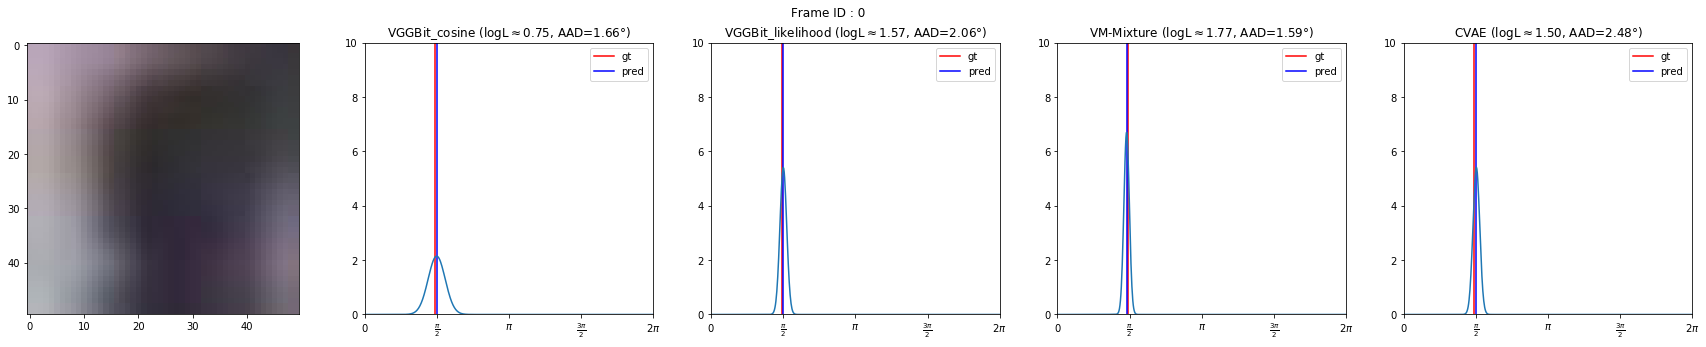

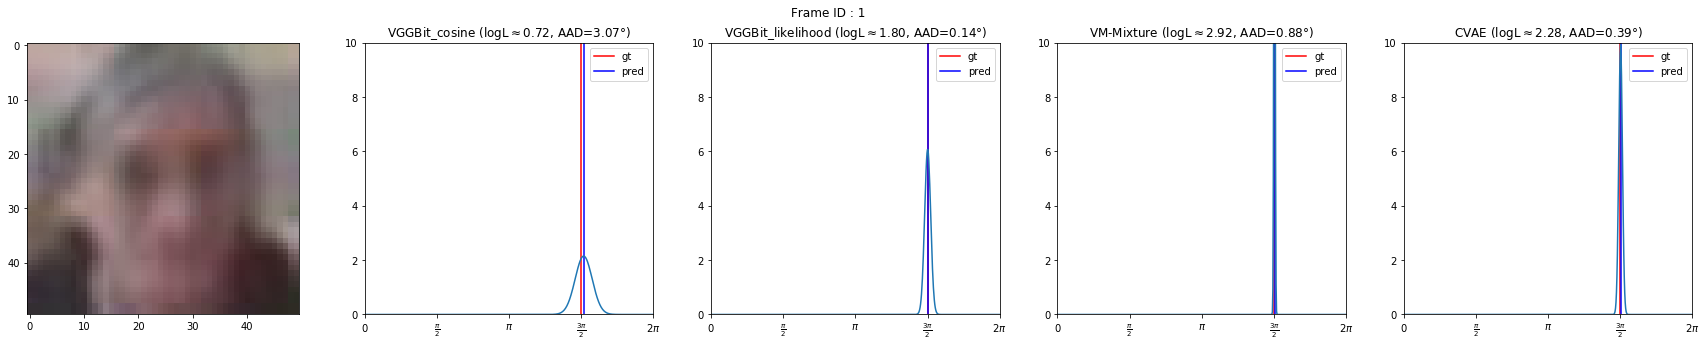

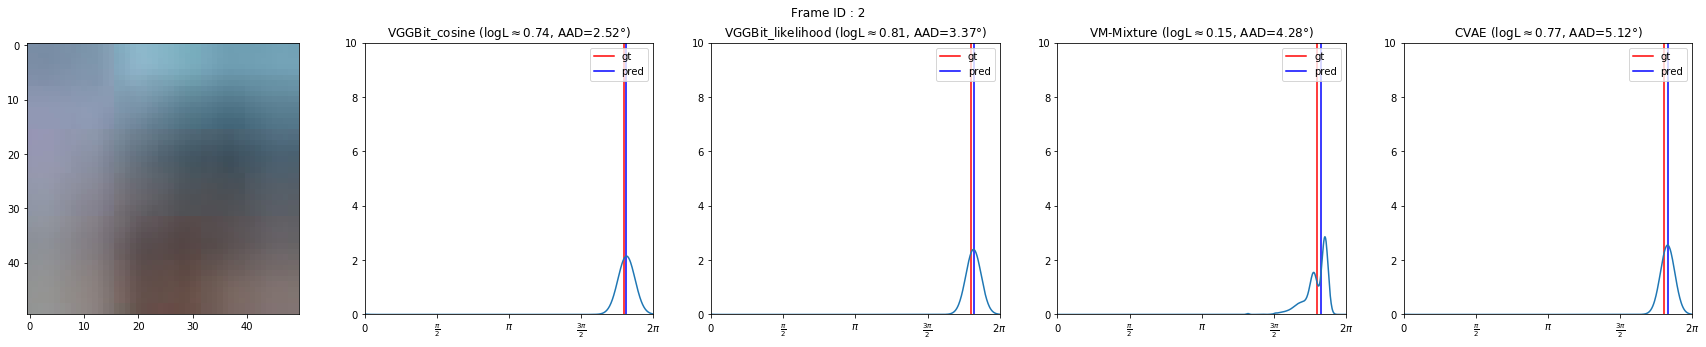

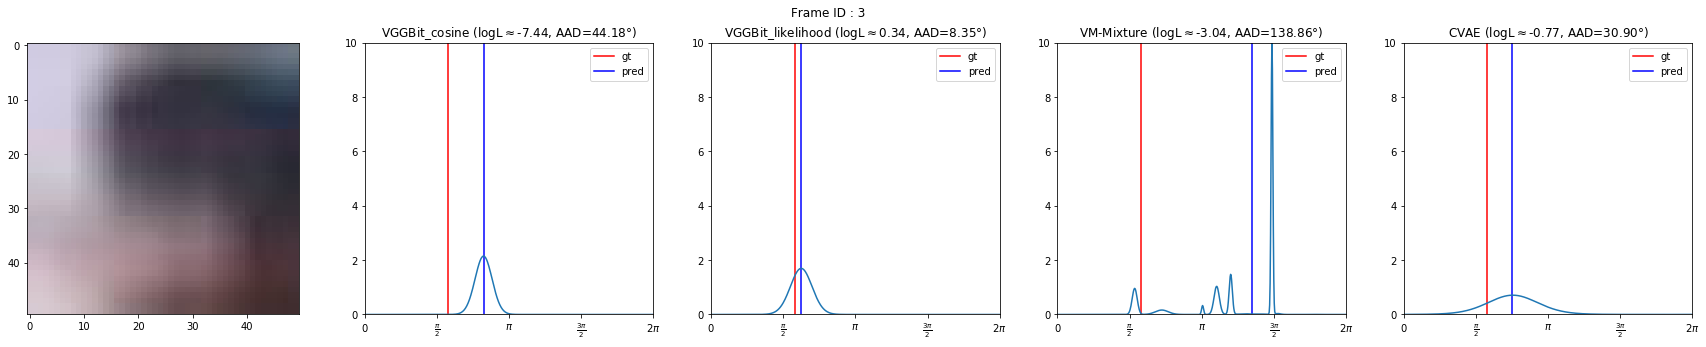

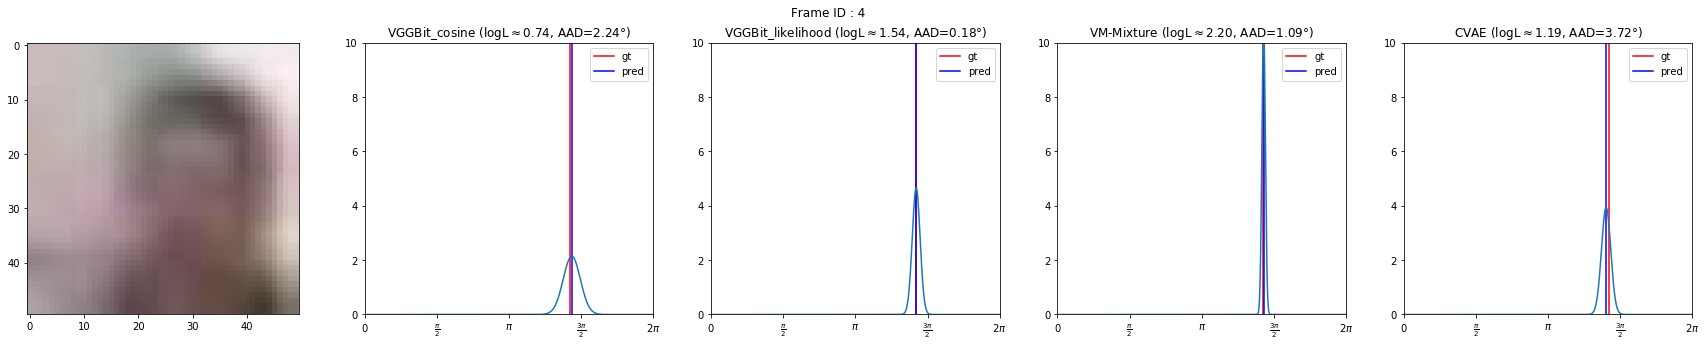

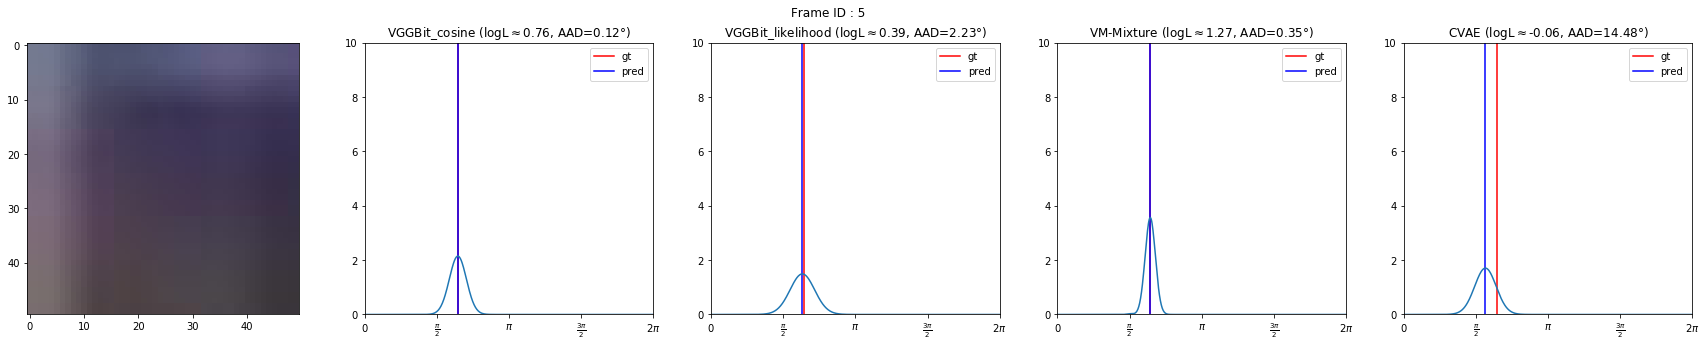

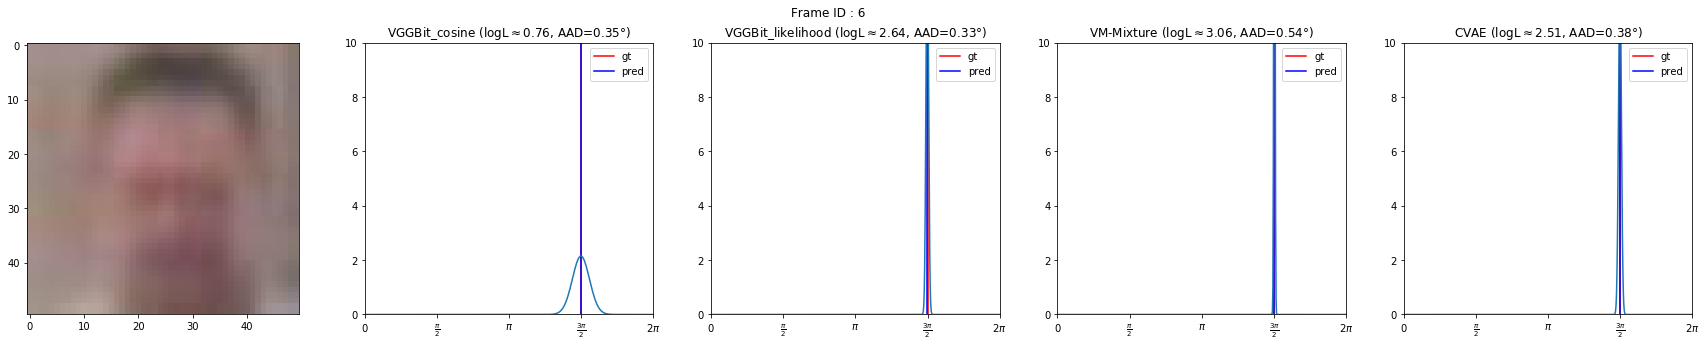

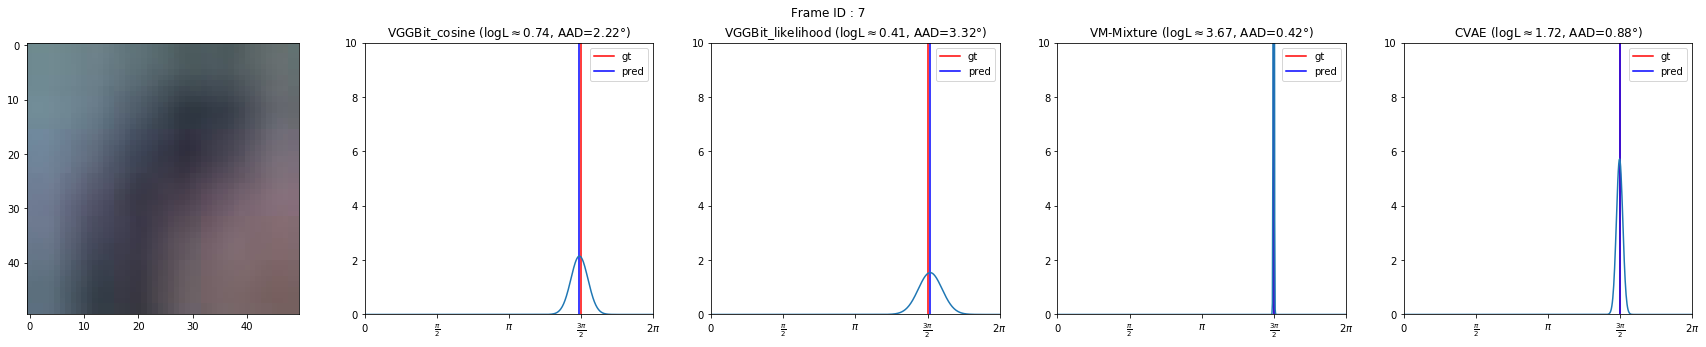

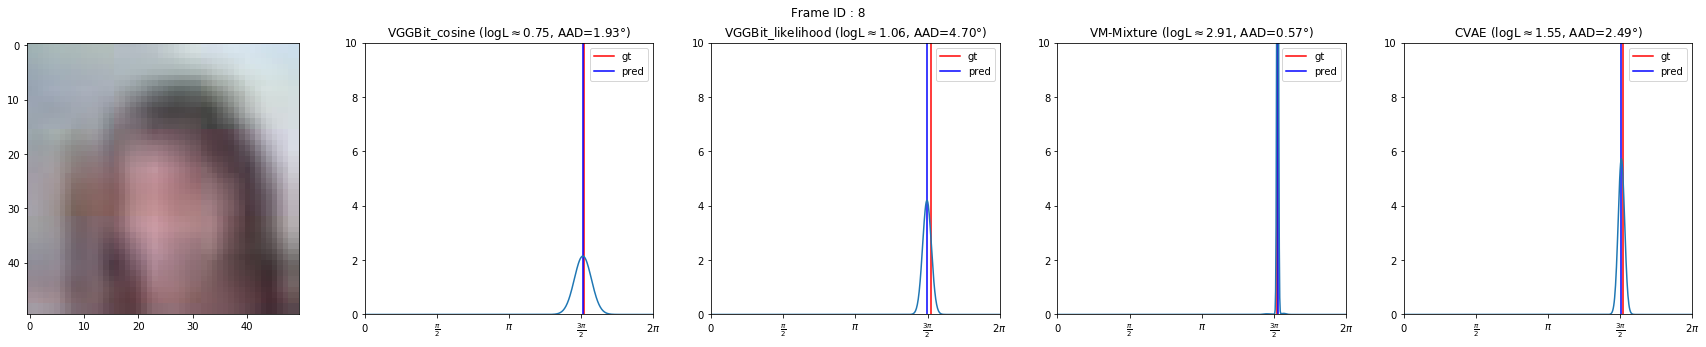

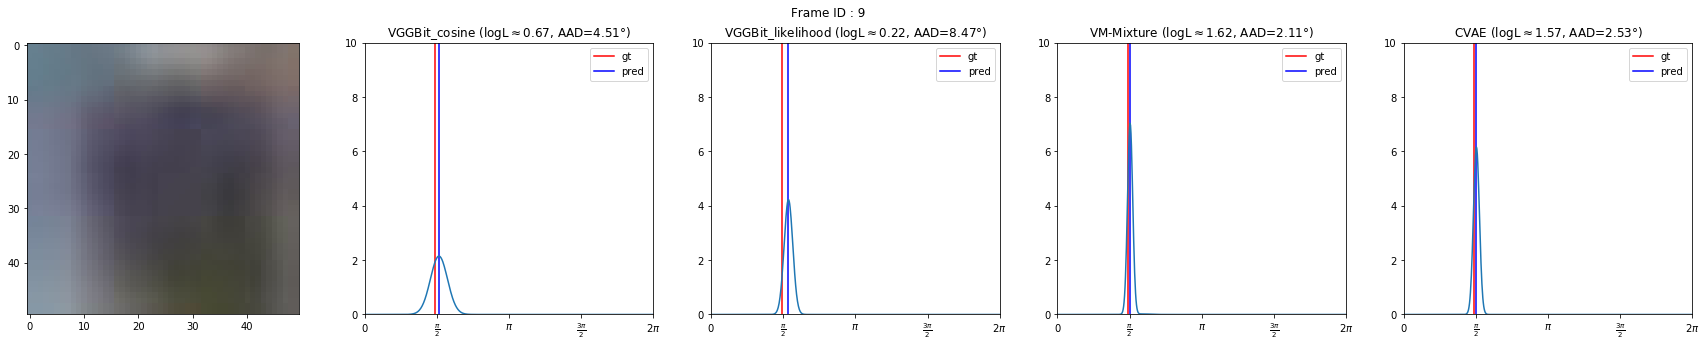

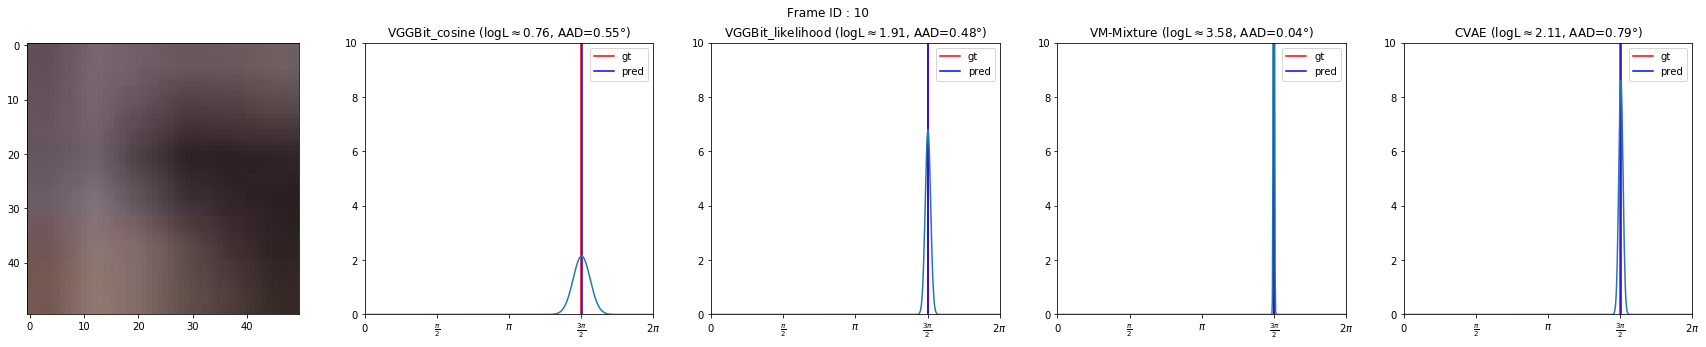

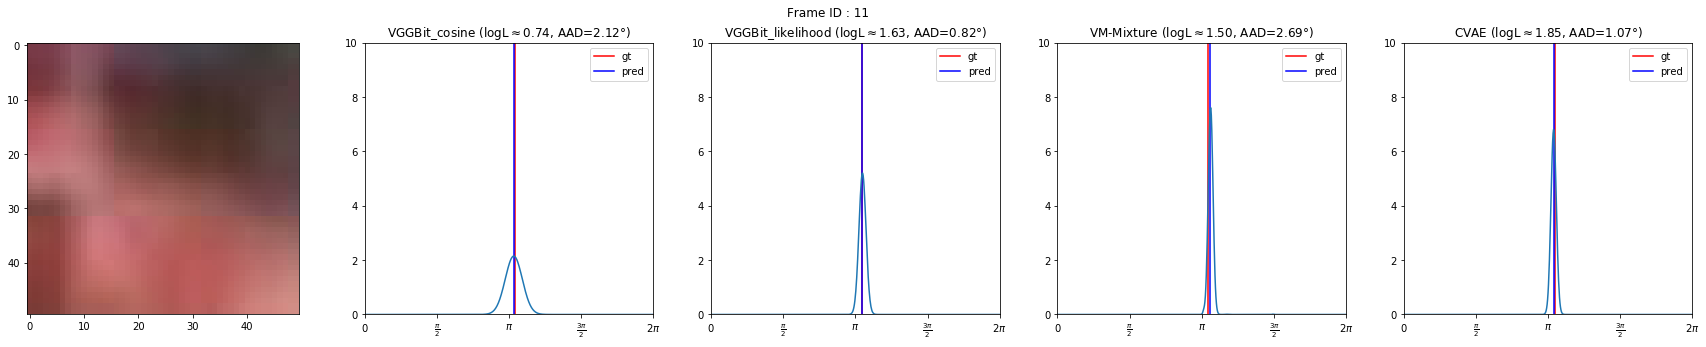

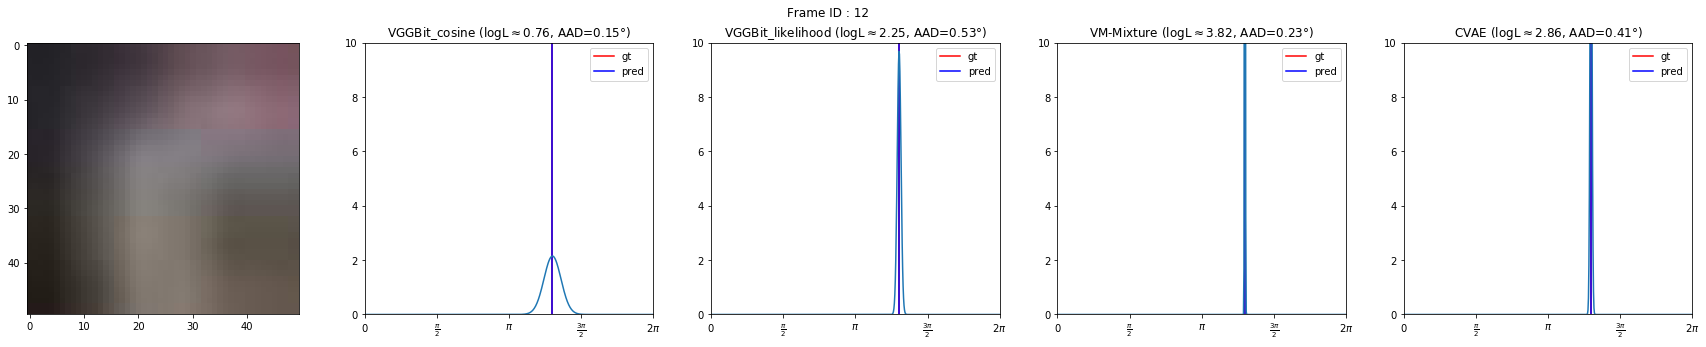

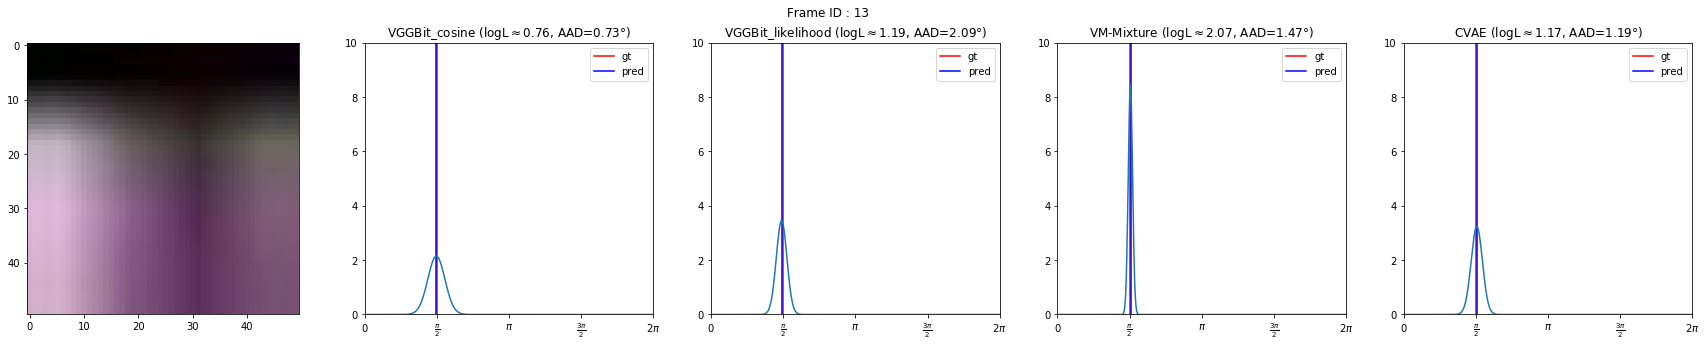

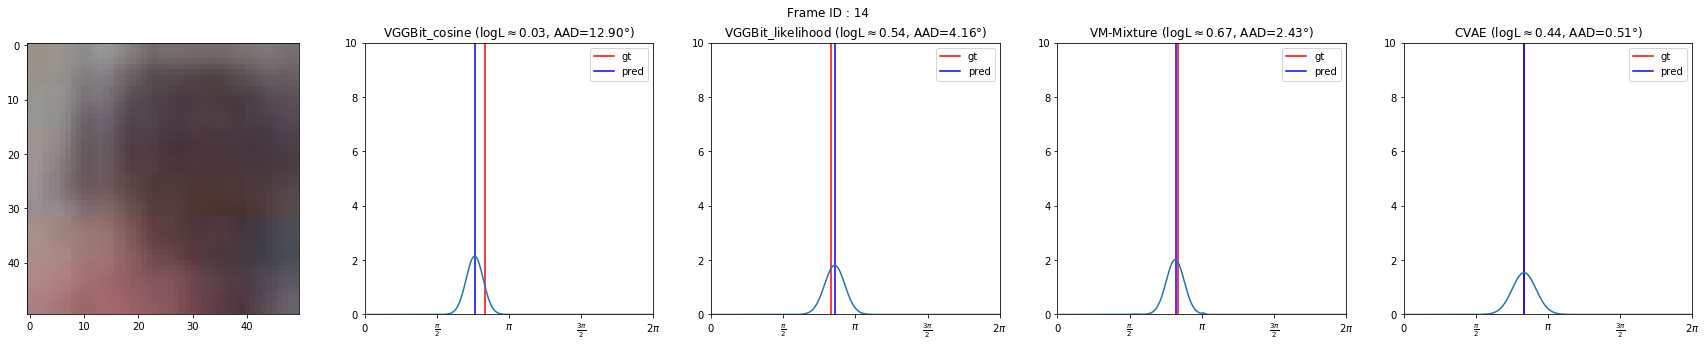

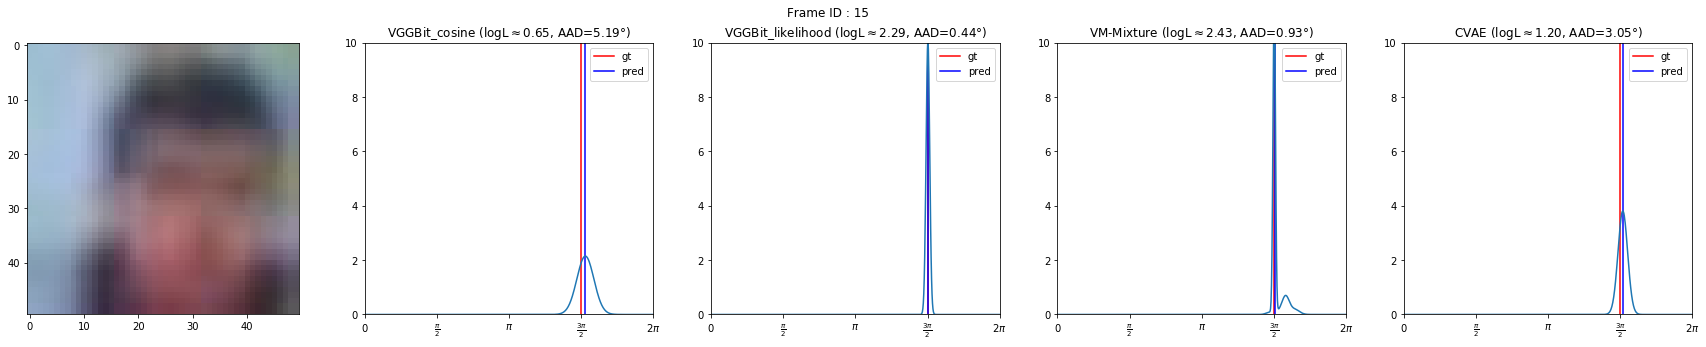

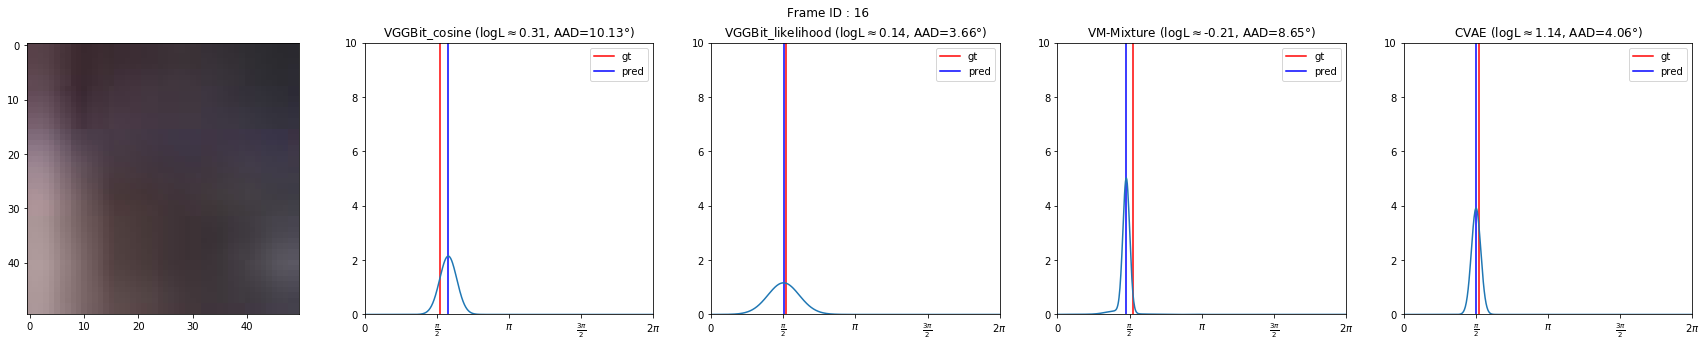

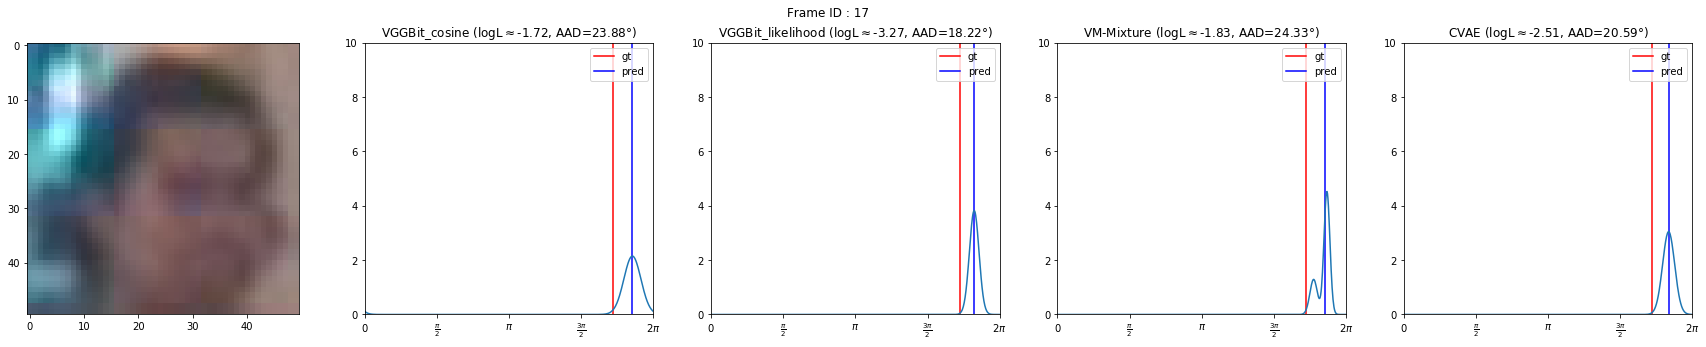

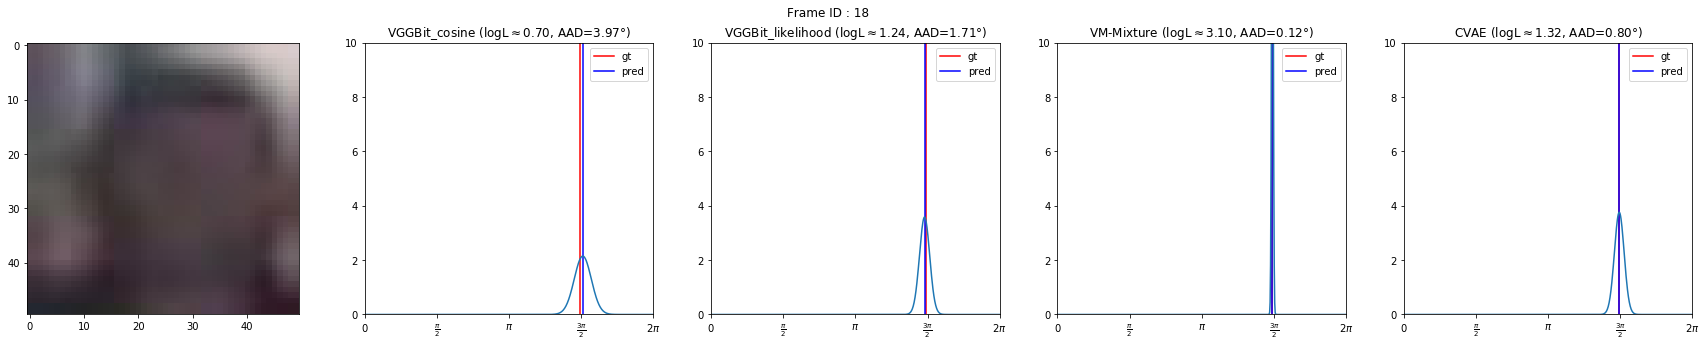

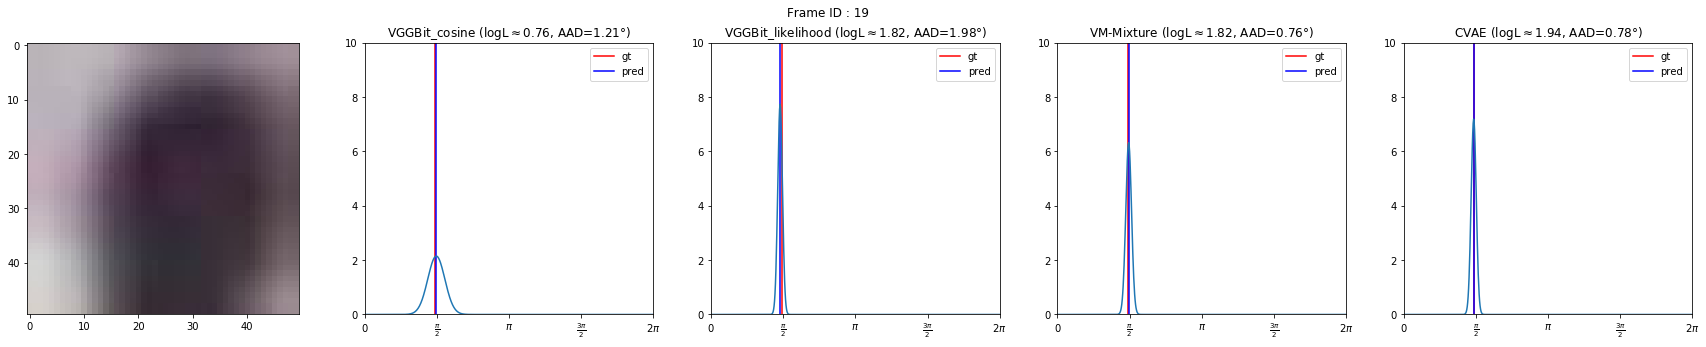

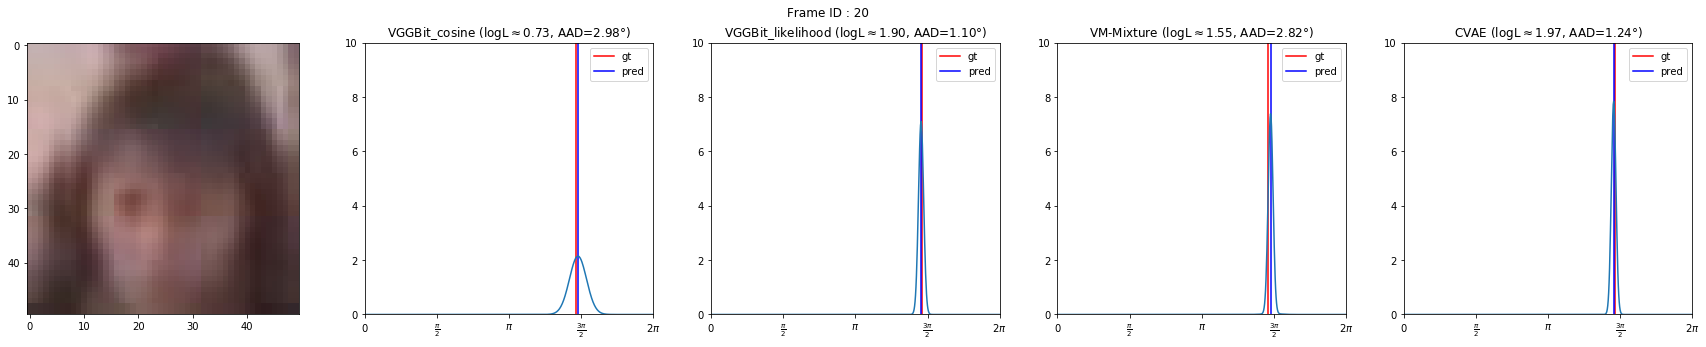

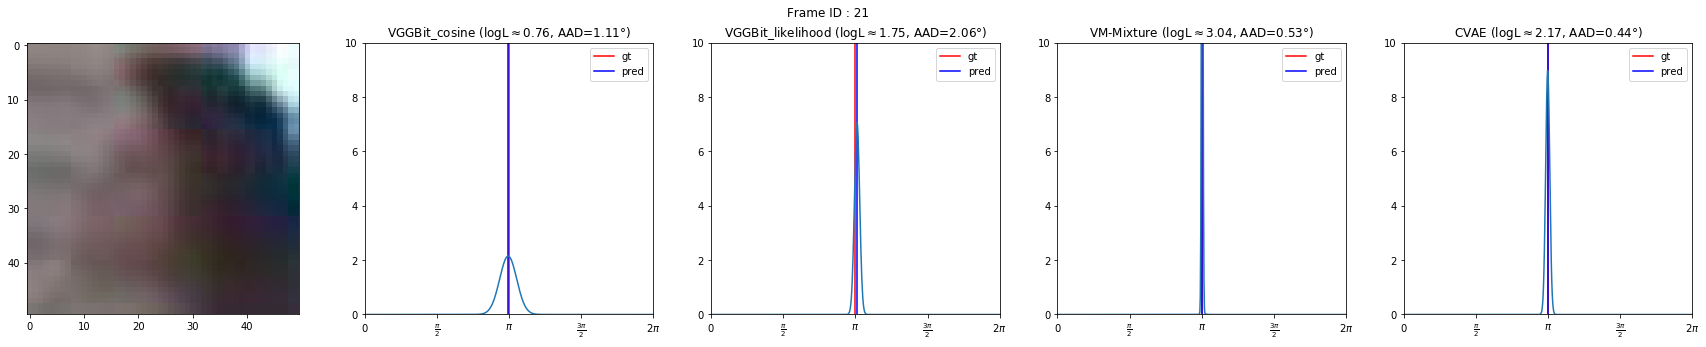

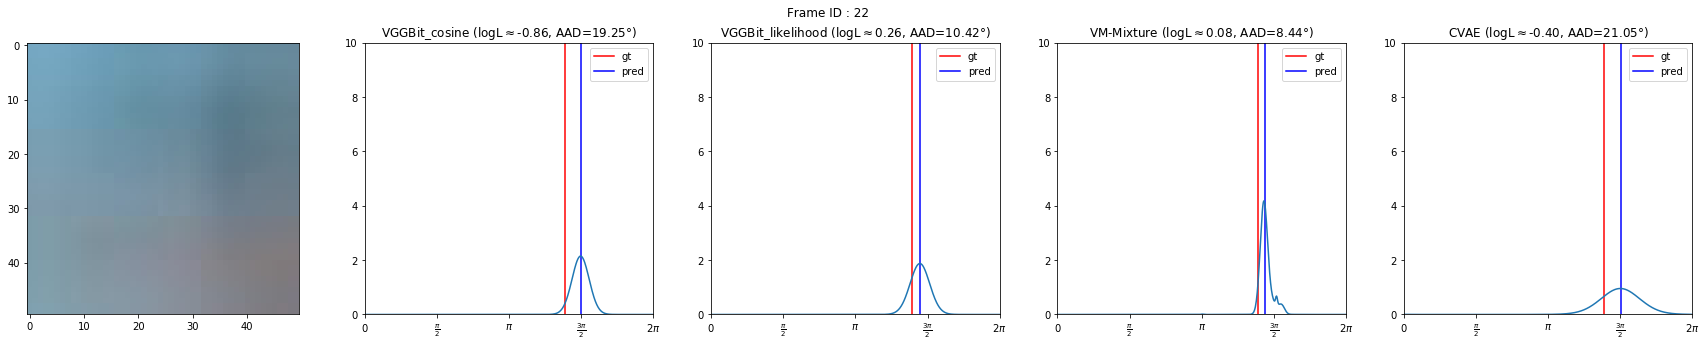

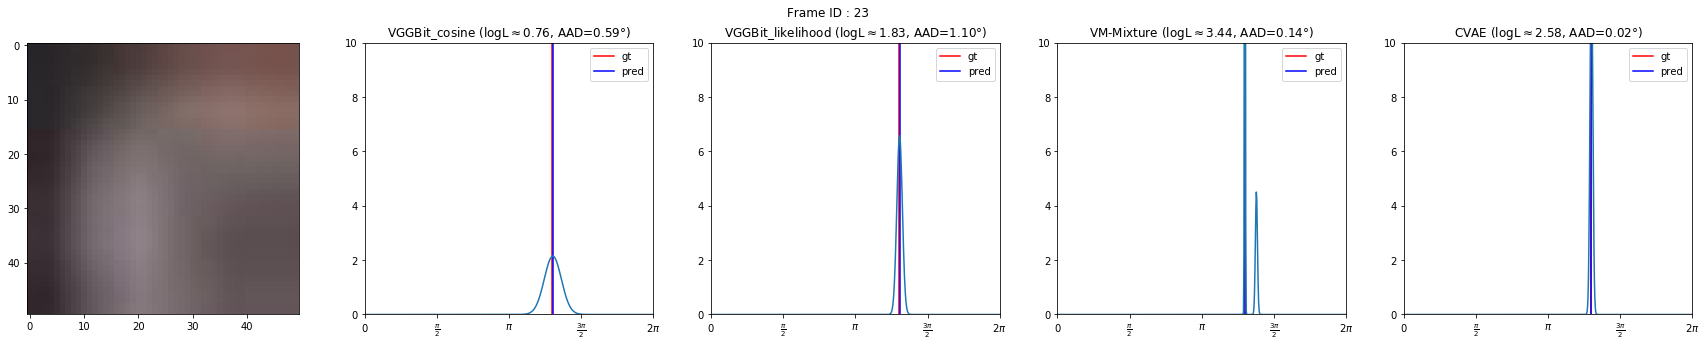

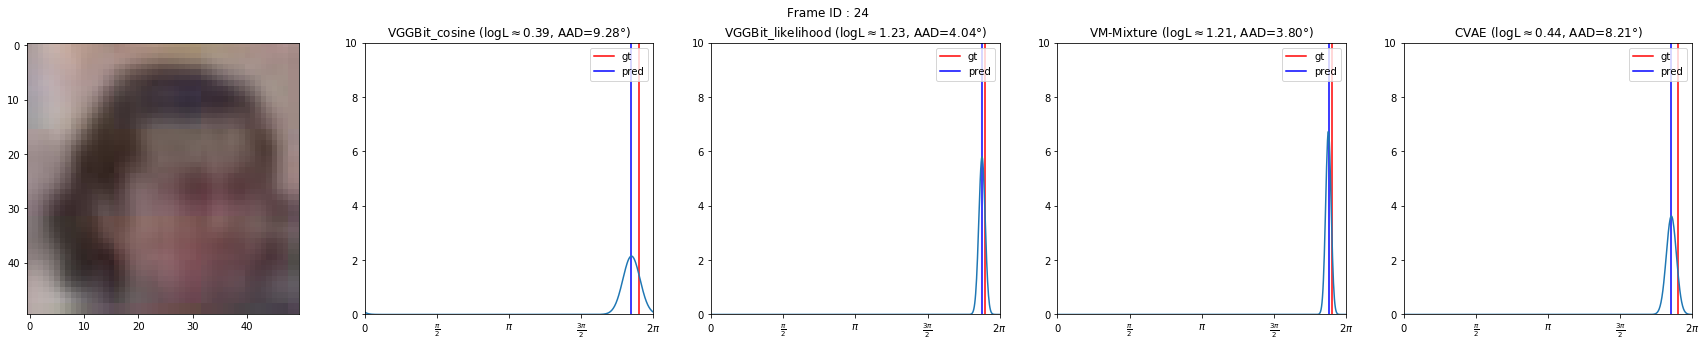

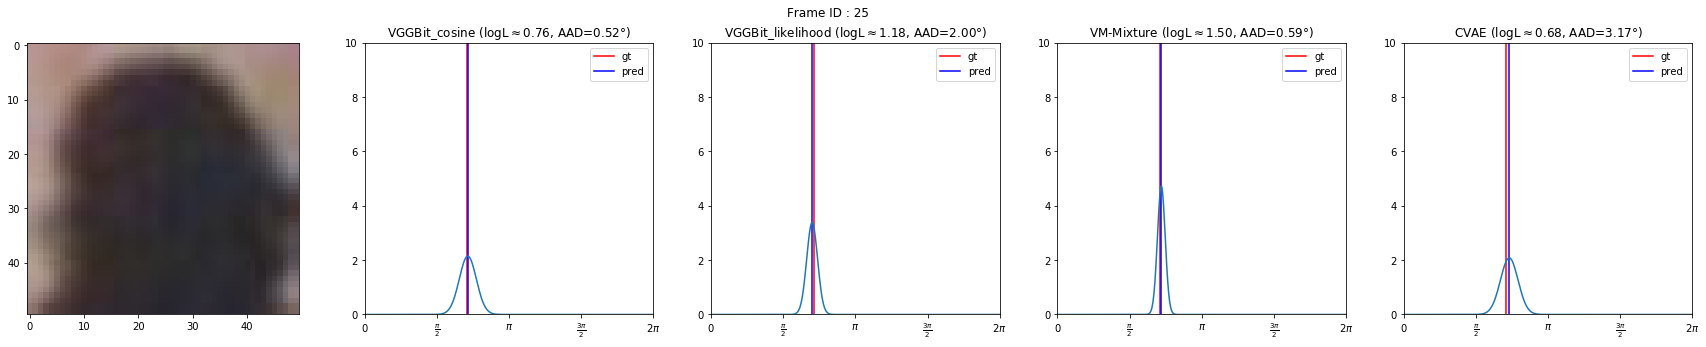

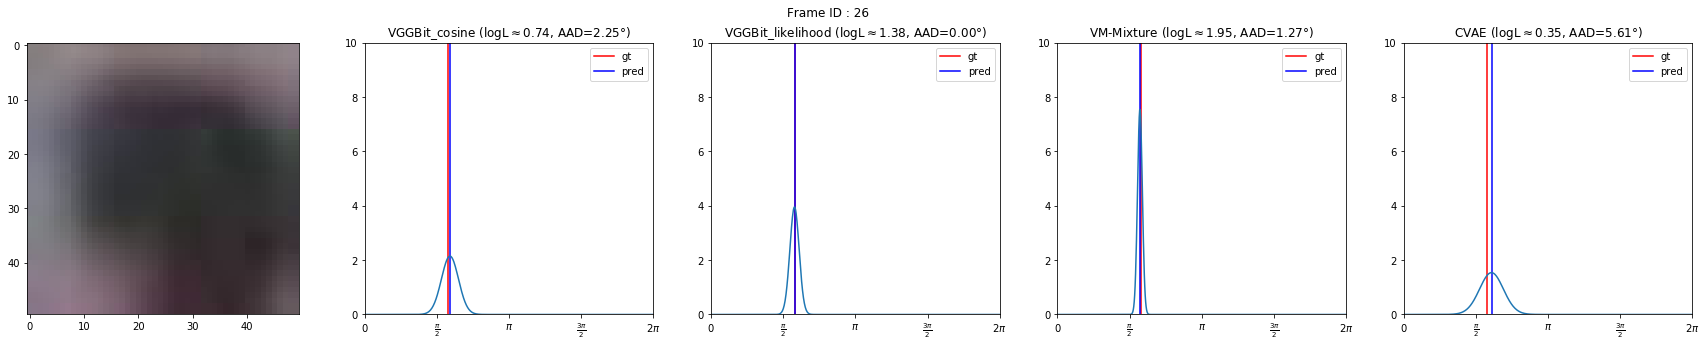

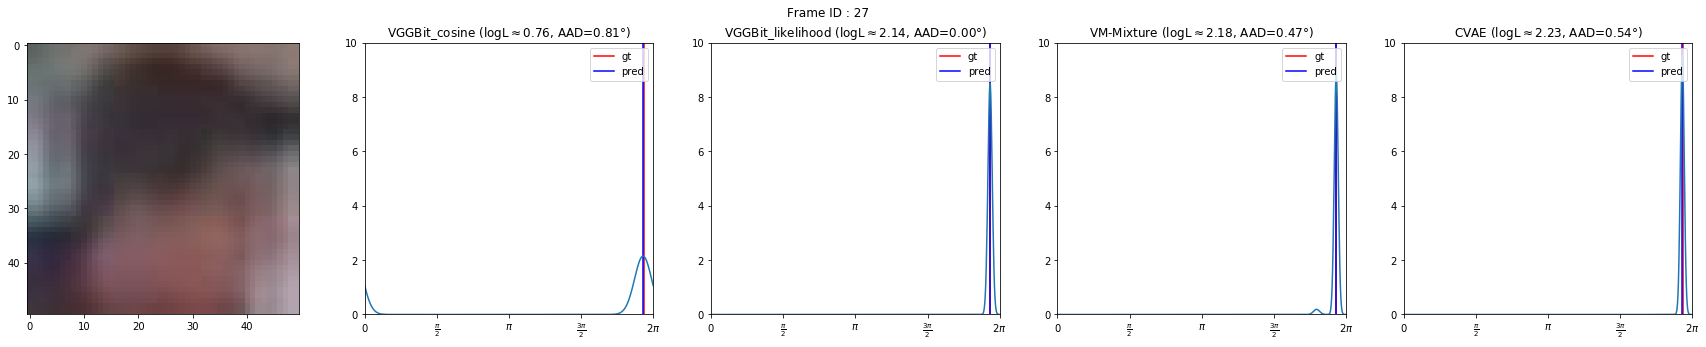

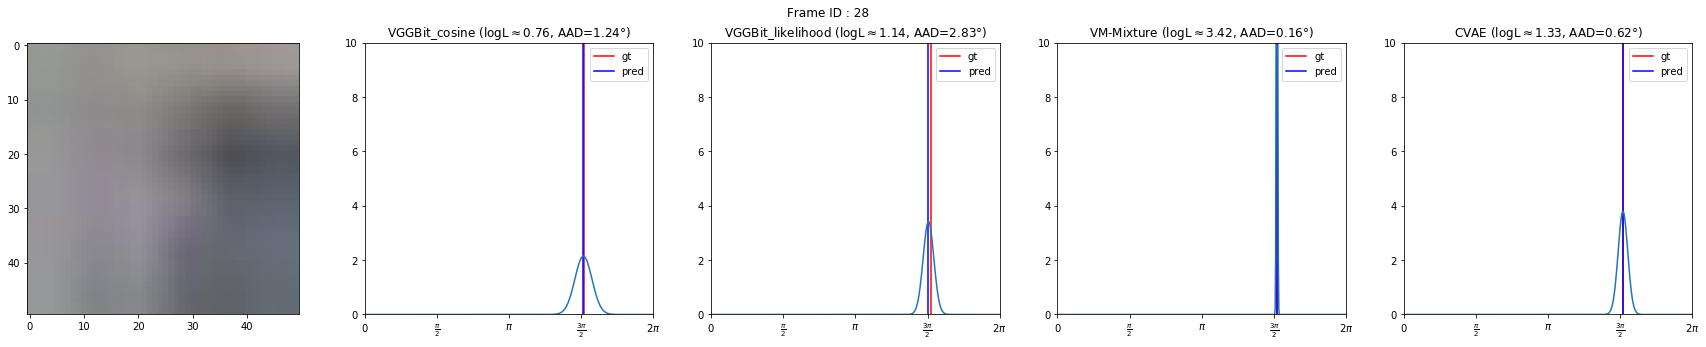

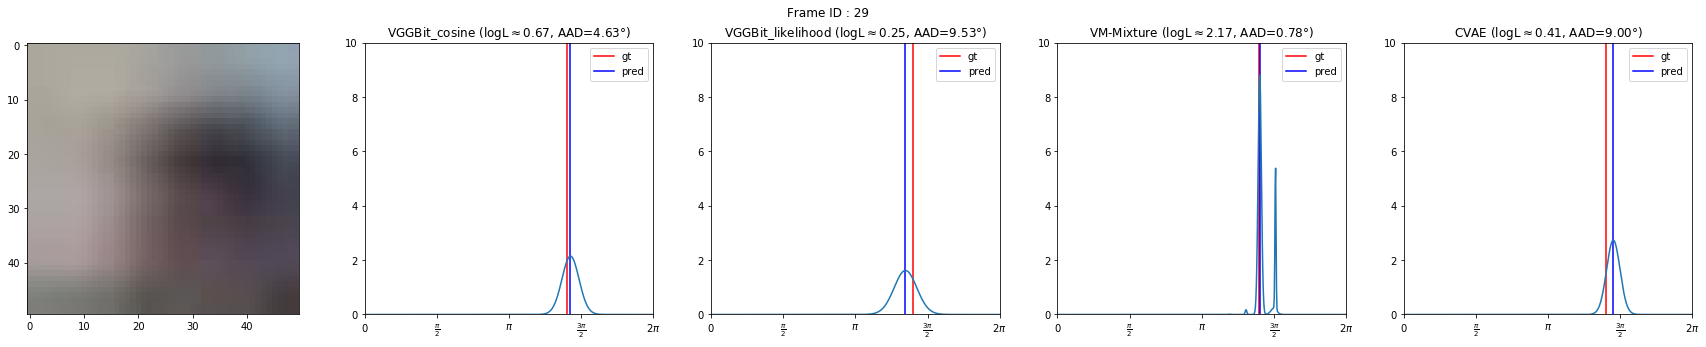

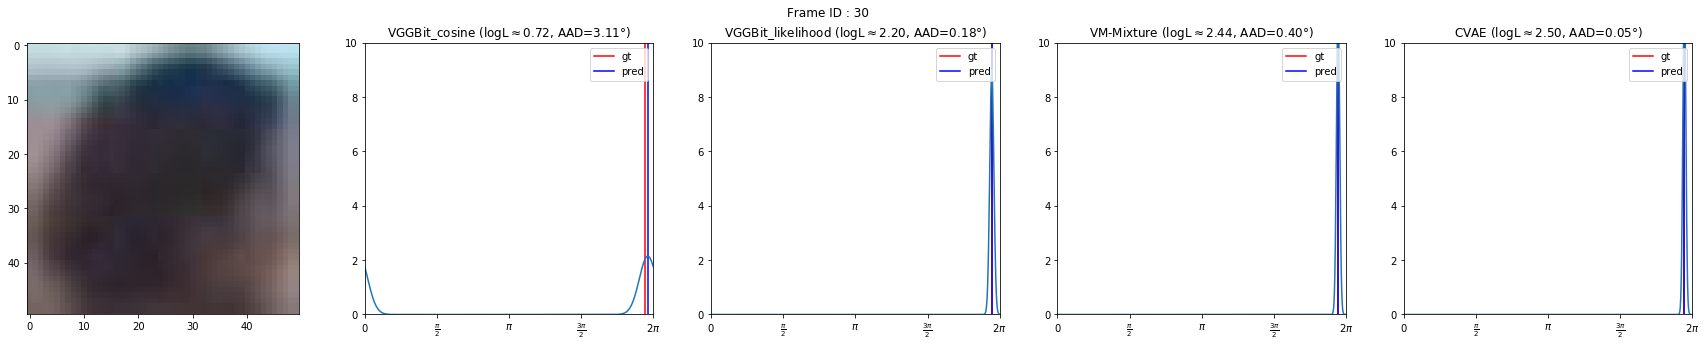

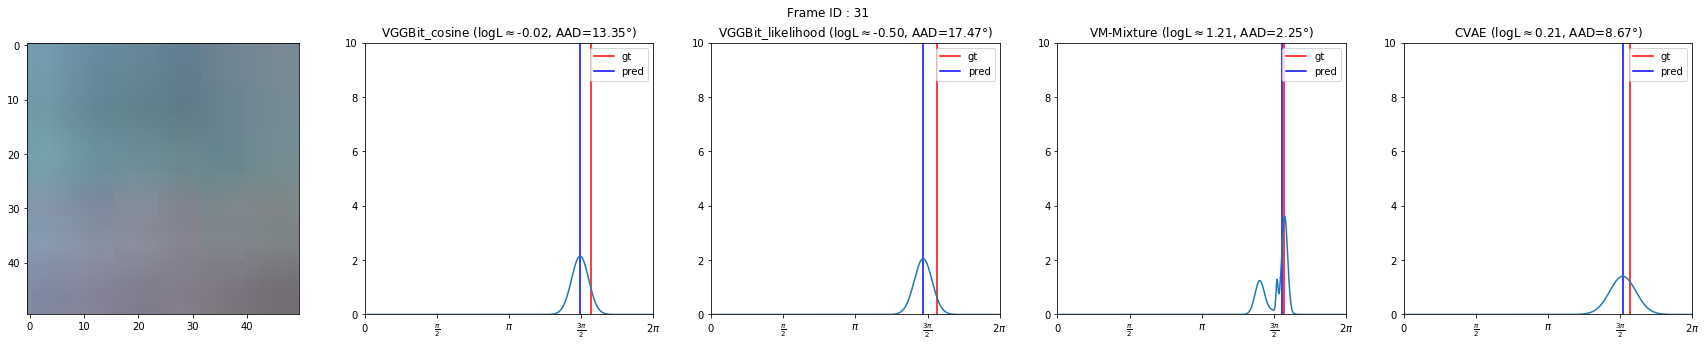

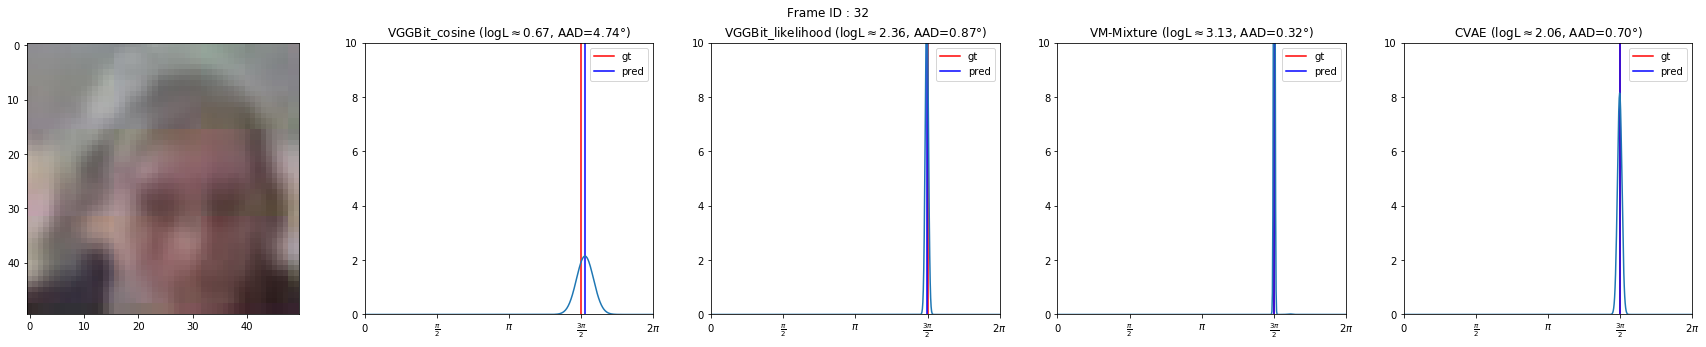

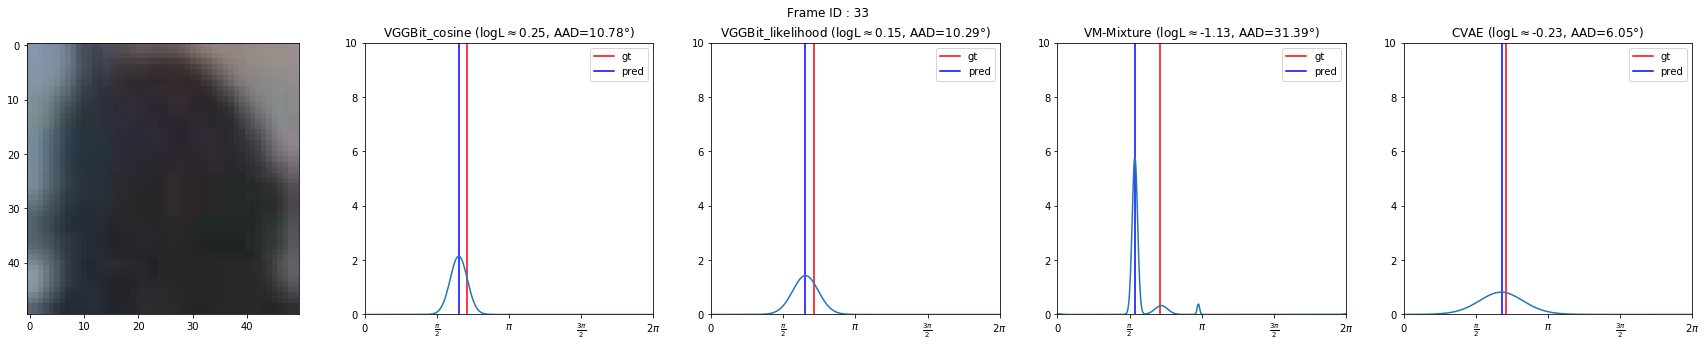

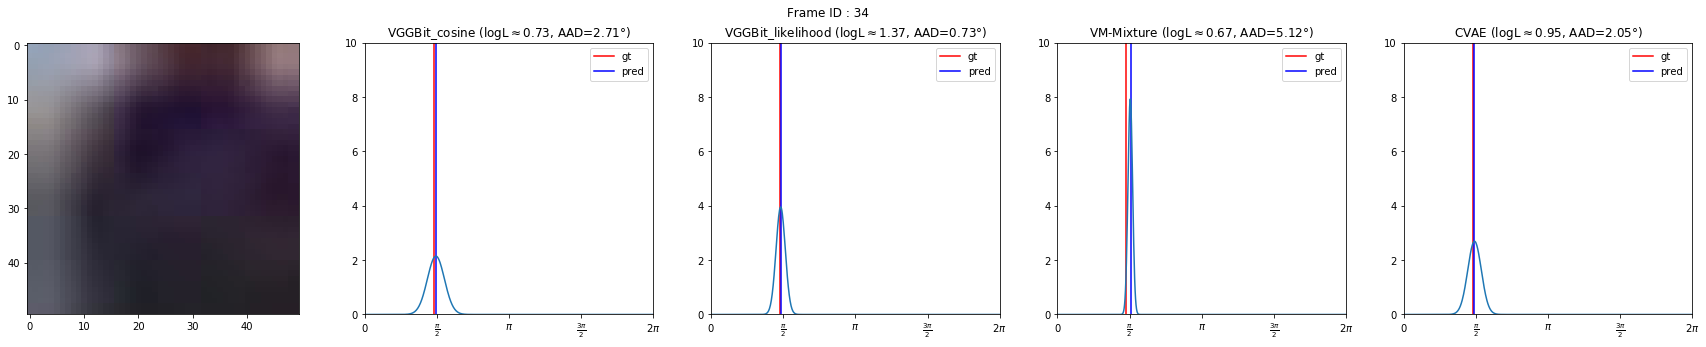

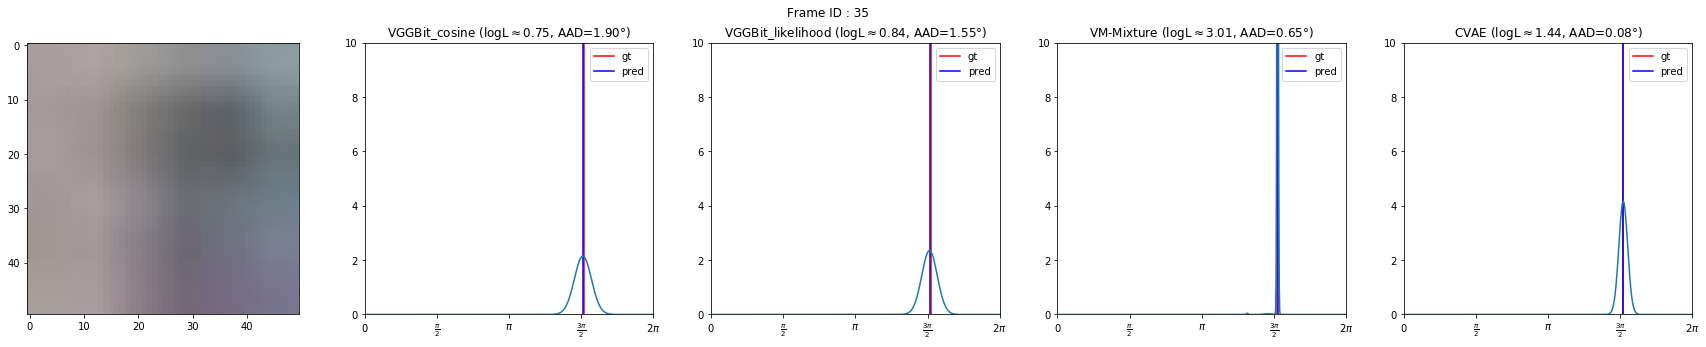

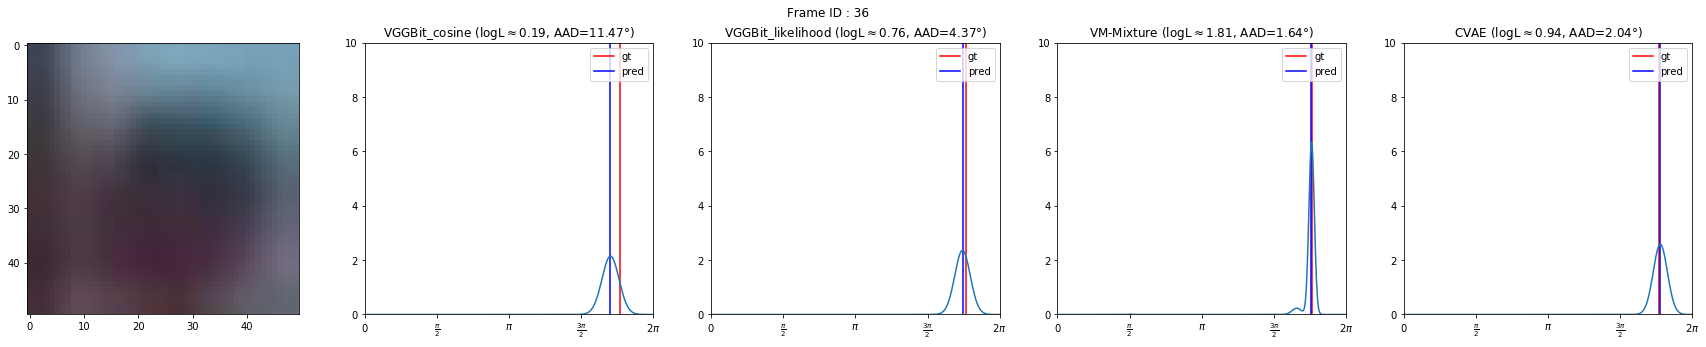

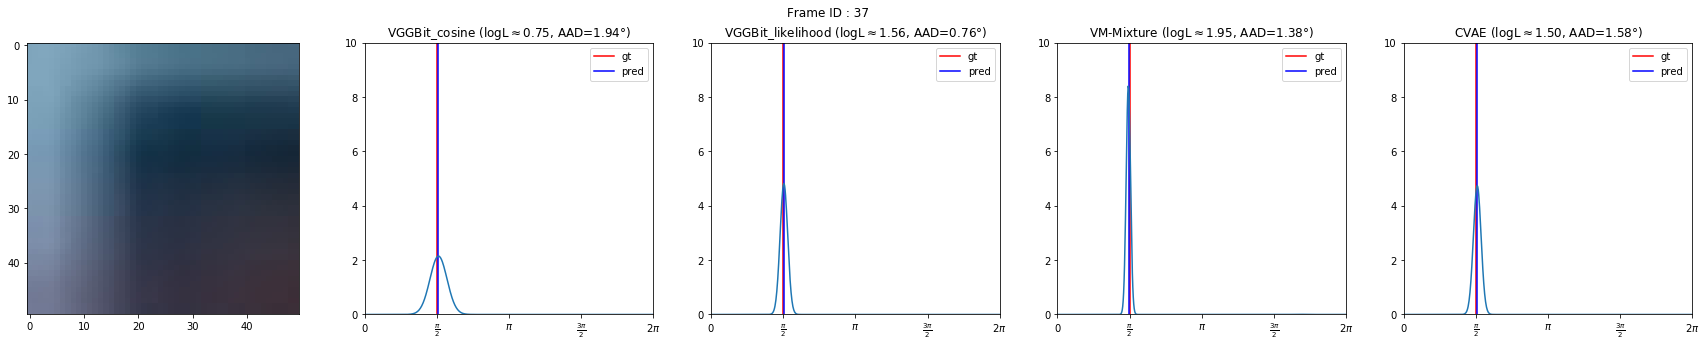

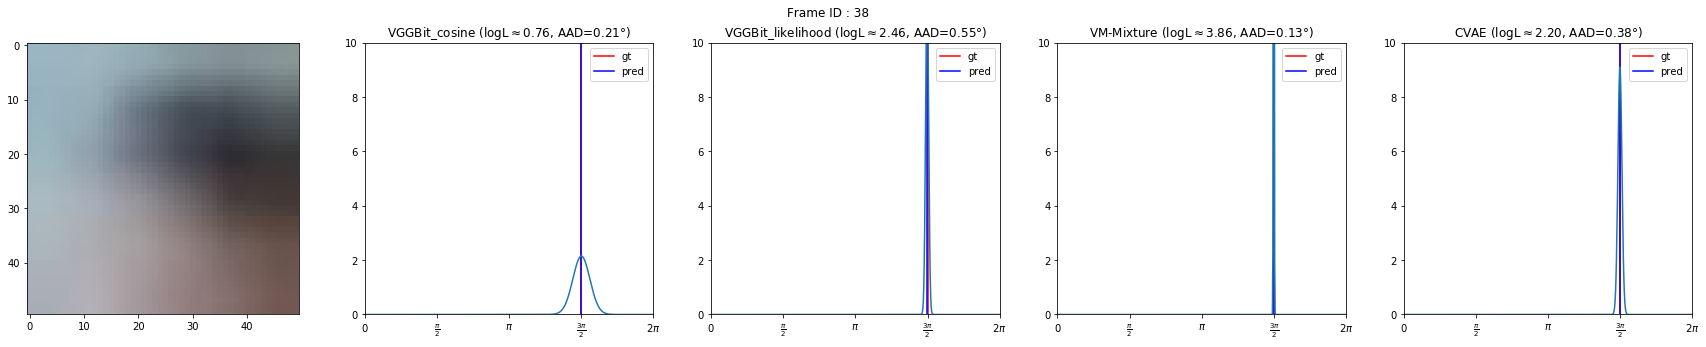

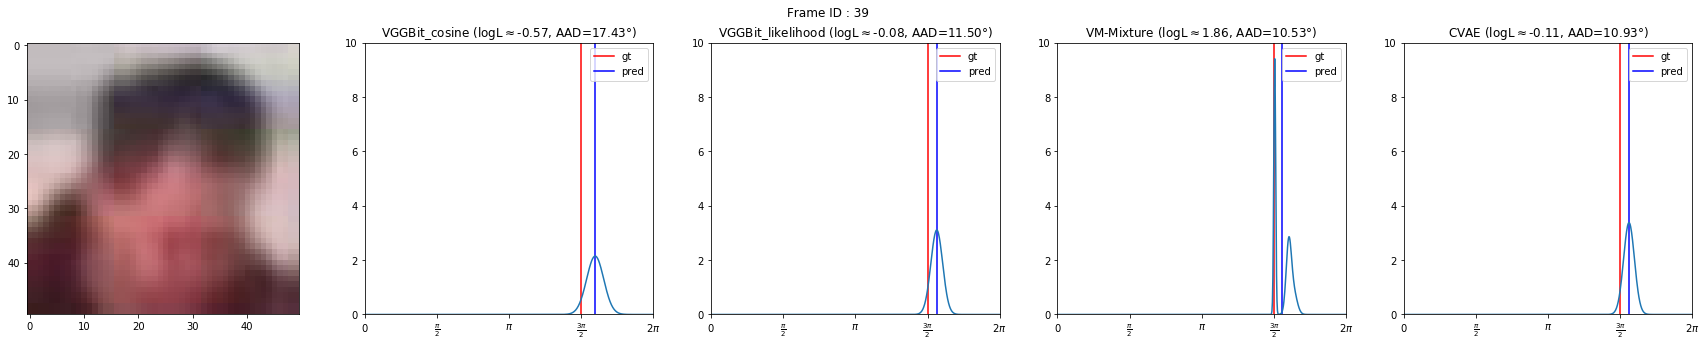

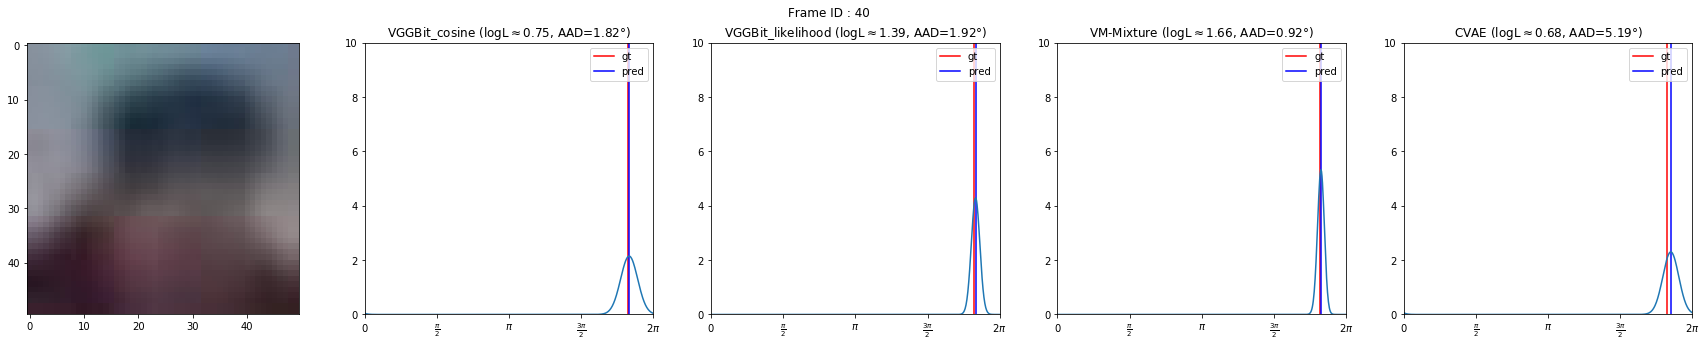

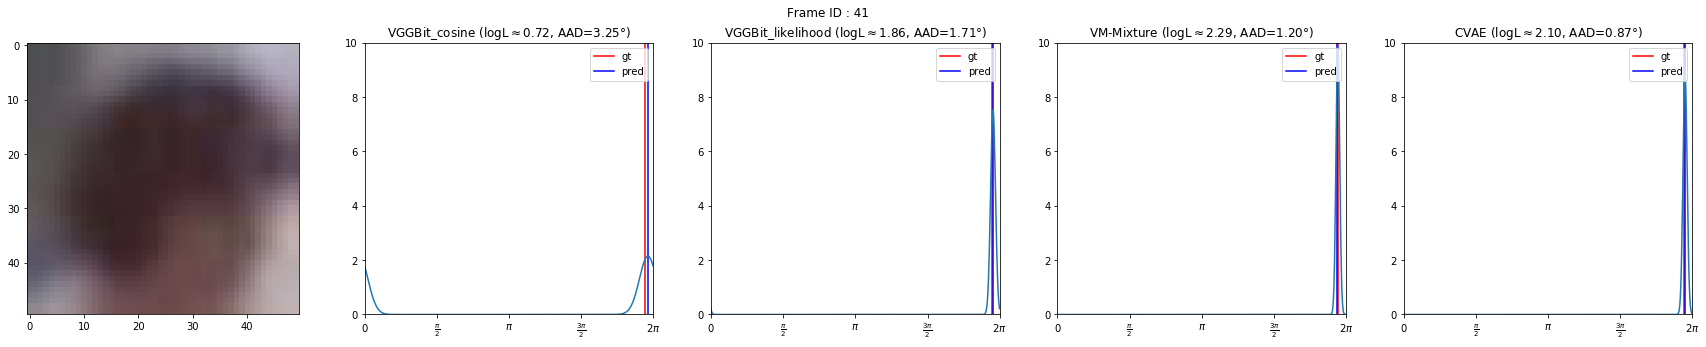

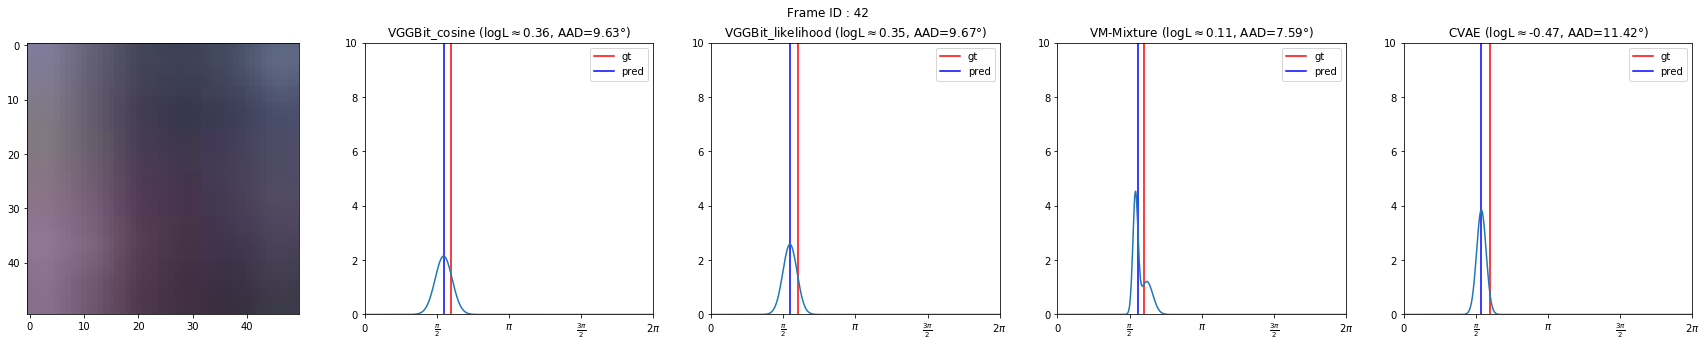

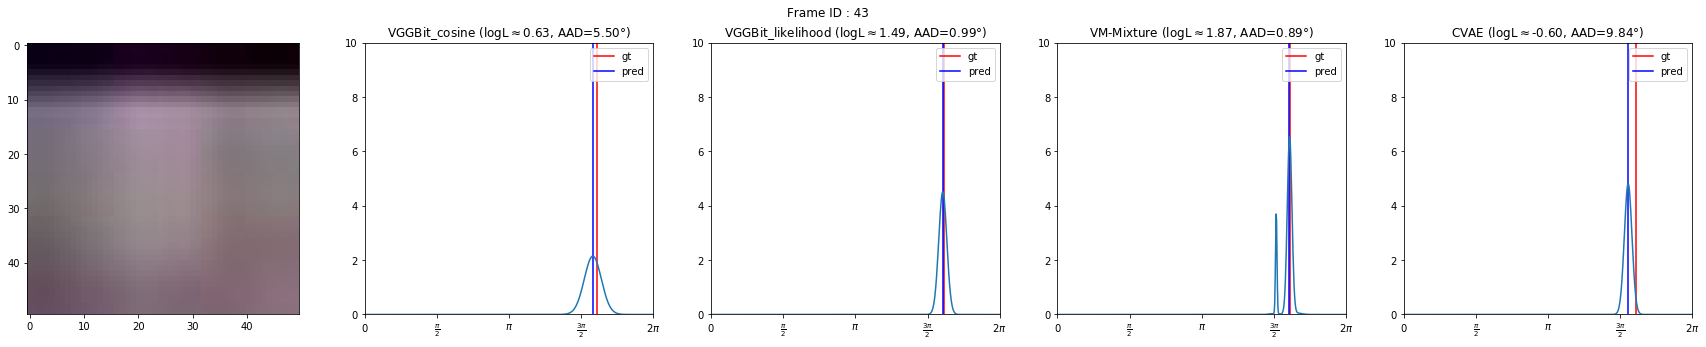

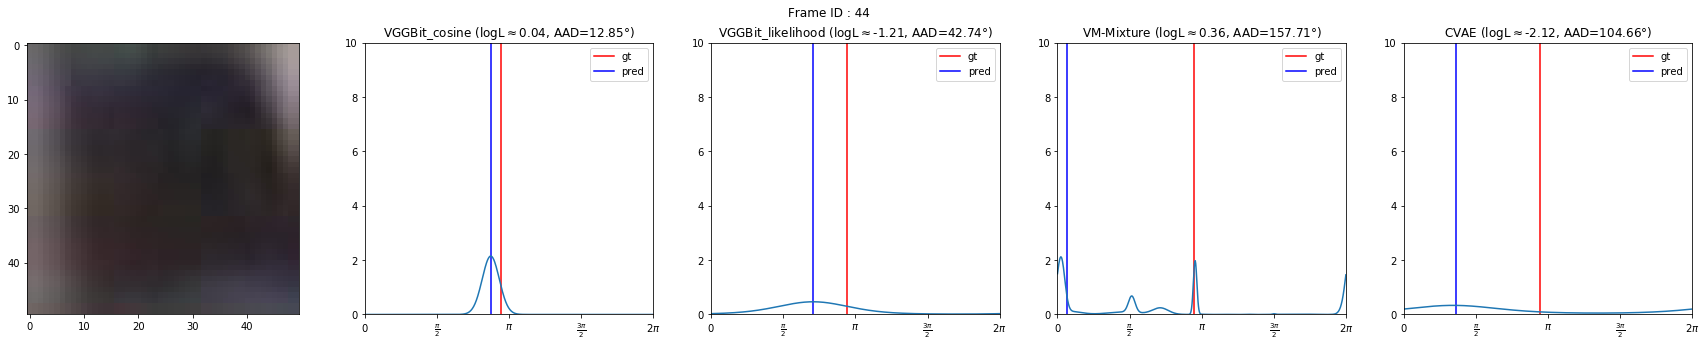

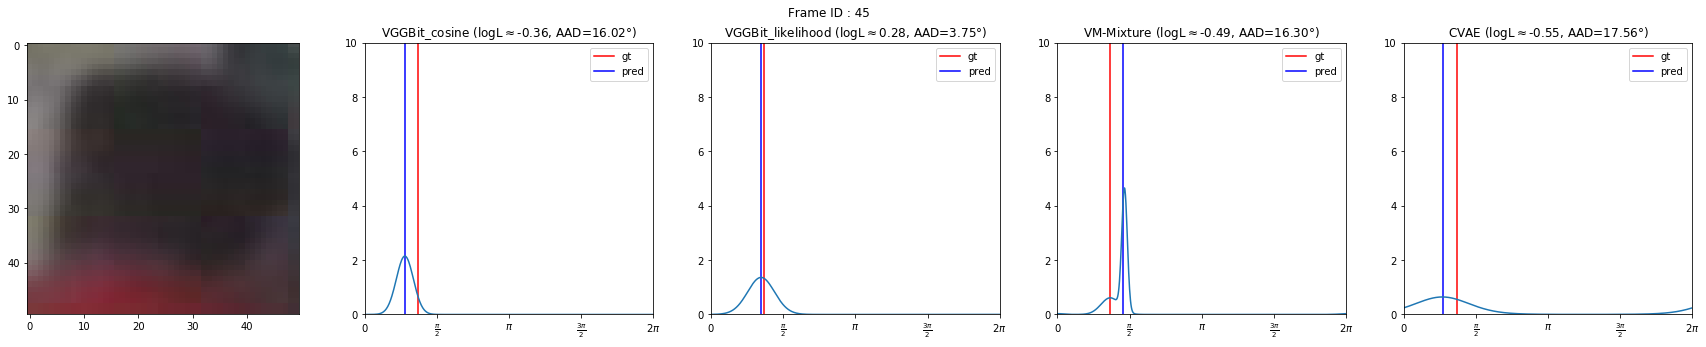

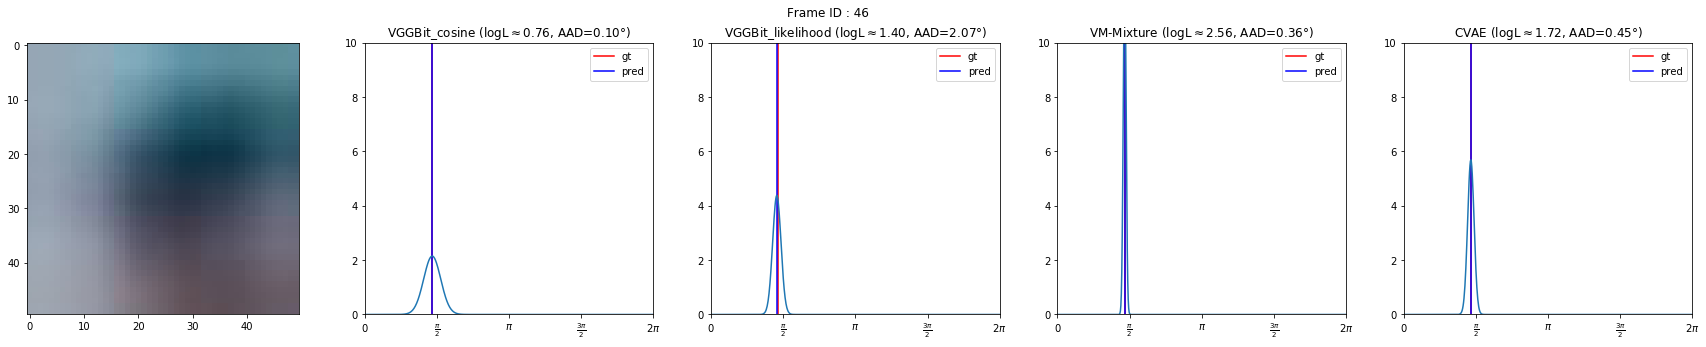

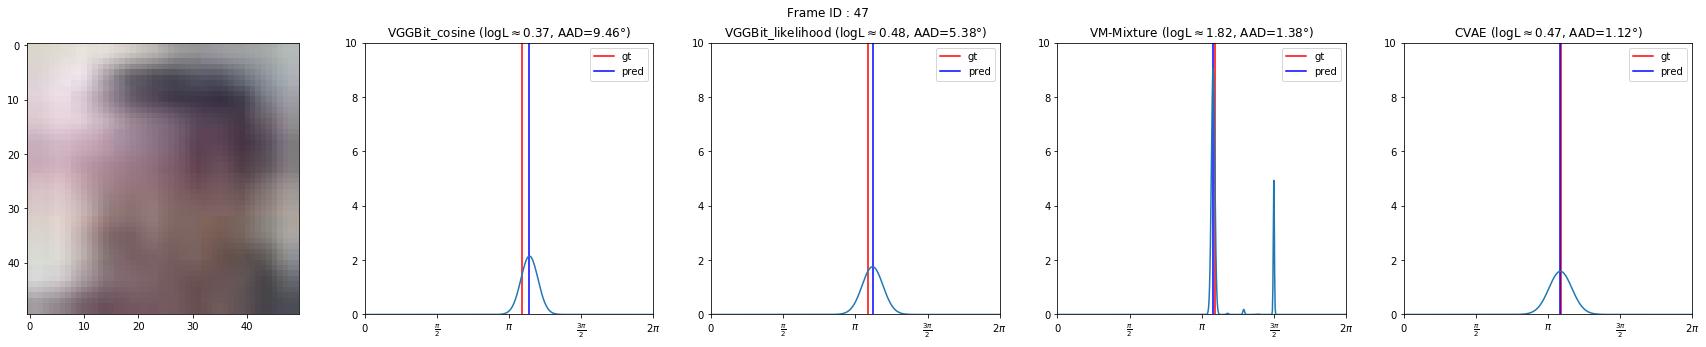

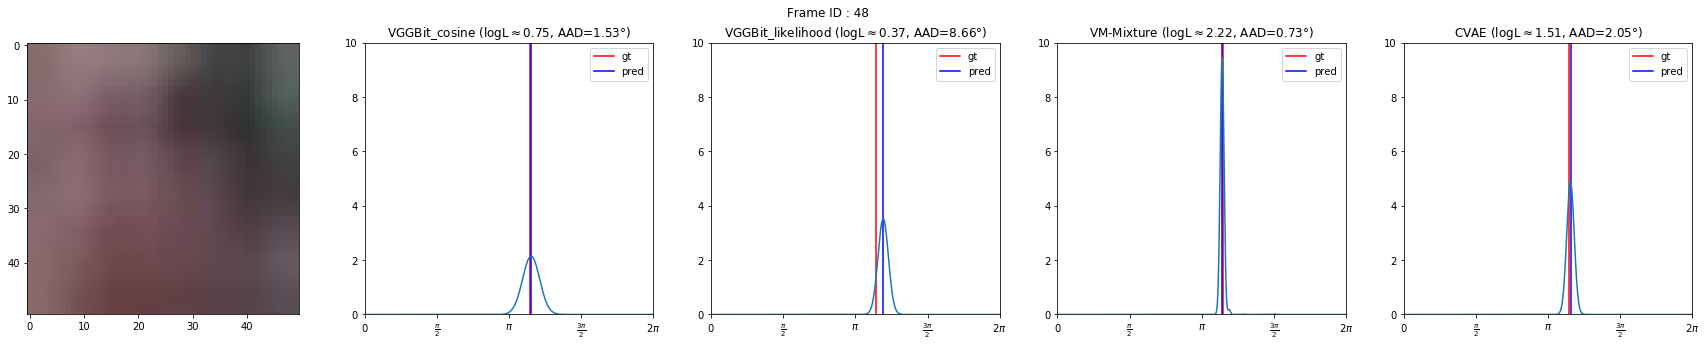

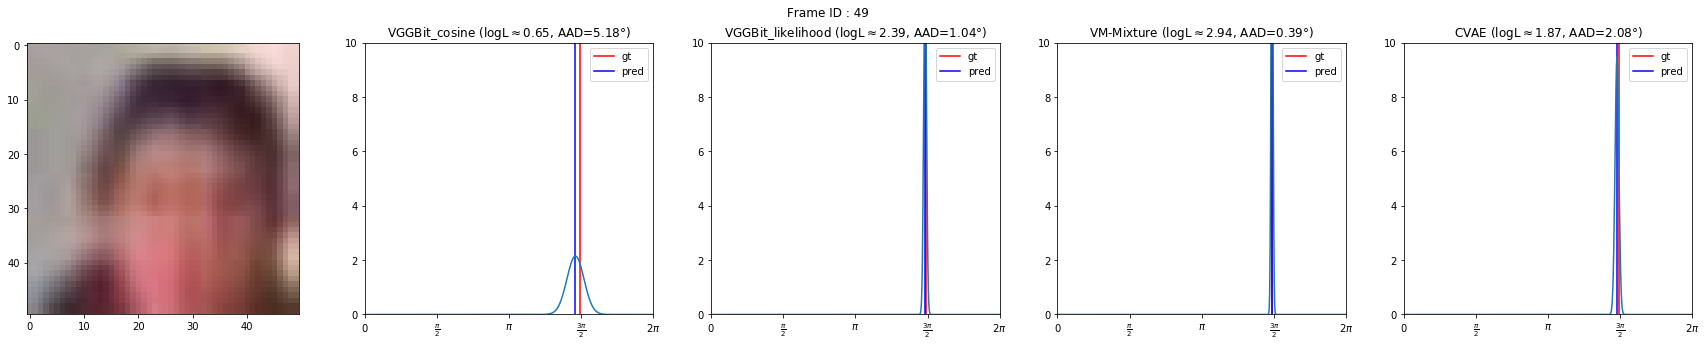

In [413]:
from utils.angles import bit2deg

yte_rad = np.deg2rad(bit2deg(yte_bit))

for fix, fid in enumerate(frames):
    
    pdfs_dict = {}
    likelihoods_dict = {}
    point_preds_dict = {}
    maad_dict = {}
    pdfs_dict['VGGBit_cosine'] = vggcosine_acc_pdf[fix]
    likelihoods_dict['VGGBit_cosine'] = results['cosine']['log_likelihood'][fix]
    maad_dict['VGGBit_cosine'] = results['cosine']['maad'][fix]
    point_preds_dict['VGGBit_cosine'] = results['cosine']['point_preds'][fix]
    pdfs_dict['VGGBit_likelihood'] = vgglikelihood_acc_pdf[fix]
    likelihoods_dict['VGGBit_likelihood'] = results['likelihood']['log_likelihood'][fix]
    maad_dict['VGGBit_likelihood'] = results['likelihood']['maad'][fix]
    point_preds_dict['VGGBit_likelihood'] = results['likelihood']['point_preds'][fix]
    pdfs_dict['VM-Mixture'] = vmmix_acc_pdf[fix]
    likelihoods_dict['VM-Mixture'] = results['mixture']['log_likelihood'][fix]
    maad_dict['VM-Mixture'] = results['mixture']['maad'][fix]
    point_preds_dict['VM-Mixture'] = results['mixture']['point_preds'][fix]
    pdfs_dict['CVAE'] = cvae_acc_pdfs[fix]
    likelihoods_dict['CVAE'] = results['cvae']['importance_log_likelihood'][fix]
    maad_dict['CVAE'] = results['cvae']['maad'][fix]
    point_preds_dict['CVAE'] = results['cvae']['point_preds'][fix]
    #plot_image_results(xte[fid], xvals, cvae_acc_pdfs[fid], cvae_samples_pdfs[fid], yte_rad[fid])
    plot_image_results(xte[fid], fid, xvals,  pdfs_dict, likelihoods_dict, maad_dict, point_preds_dict, yte_rad[fid])

In [384]:
results['mixture']['point_preds'][3]

-93.303900421536724

In [415]:
int(245/10)

24

In [314]:
np.squeeze(results['likelihood']['log_likelihood'])<np.squeeze(results['mixture']['log_likelihood'])-0.5

array([False,  True,  True,  True, False,  True,  True, False,  True,
        True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True, False,  True, False, False,  True, False,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
       False,  True, False, False,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True, False,  True,  True, False,
        True,  True,  True,  True, False,  True,  True, False,  True,
        True,  True,  True, False,  True,  True, False, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True, False], dtype=bool)

In [320]:
results['likelihood']['log_likelihood'][77]

array([-22.22556305])

In [321]:
results['mixture']['log_likelihood'][77]

0.4351661233387033

In [327]:
results['cvae']['importance_log_likelihood'][77]

-2.238389335326517

In [ ]:
results['cvae'] = cvae_model.evaluate(x, y_deg, data_part, return_per_image=True)

In [318]:
np.argsort(np.squeeze(results['likelihood']['maad']))

array([21, 85, 11, 67, 71, 15, 29, 80, 62, 66, 39, 91, 98, 58, 94,  7, 74,
       42, 34, 36, 25, 13, 75, 54, 70, 28, 12, 78, 23, 26, 50, 59,  1, 65,
       46, 86, 20, 51,  9, 72, 89,  6, 97, 52, 90, 18, 44, 19, 82, 63, 61,
        8, 60, 69, 10, 37, 49, 55, 73, 68, 35, 47, 99,  0, 40, 88, 57, 53,
       93, 41,  5, 83, 22, 48, 14, 64,  3, 84,  2, 43, 92, 38, 96, 33, 95,
       24, 56, 81, 87, 45, 30, 17, 27, 79, 76,  4, 16, 31, 32, 77])

In [334]:
cvae_model.evaluate(xte[275:280], yte_deg[275:280], 'test', return_per_image=True)

MAAD error (test) : 20.760905 pm 11.236111SEM
ELBO (test) : 0.034645 pm 0.779676SEM
Approx Log-Likelihood, importance sampling (test) : 0.042313 pm 0.778954SEM
KL-div (test) : 0.000365 pm0.000108SEM


{'elbo': 0.034645423152275028,
 'elbo_sem': array([ 0.77967594]),
 'importance_log_likelihood': array([ 1.67331522, -0.65733112, -2.27562039,  1.8870329 , -0.41583184]),
 'importance_log_likelihood_sem': 0.77895357799218168,
 'kl_div': 0.00036525858740787953,
 'kl_div_sem': array([ 0.00010844]),
 'maad': array([  0.07646069,  22.8746215 ,  62.29593152,   2.07278874,  16.48472212]),
 'maad_loss': 20.760904915393315,
 'maad_loss_sem': 11.236111184386829}

In [337]:
np.sort(np.squeeze(results['mixture']['log_likelihood']))

array([-44.49668224, -15.57452035, -10.11617915,  -8.14019907,
        -7.52881148,  -4.81448744,  -3.75946444,  -3.53795423,
        -2.00895022,  -1.8065433 ,  -1.78022069,  -1.66309838,
        -1.65039339,  -1.09323448,  -0.79641974,  -0.36125637,
         0.28012353,   0.3846318 ,   0.43516612,   0.43942299,
         1.09484984,   1.21881937,   1.23633501,   1.37040638,
         1.37967904,   1.68860796,   1.77874228,   1.78950512,
         1.79849765,   1.80290359,   1.85982728,   1.88094591,
         1.88344944,   1.89956665,   1.92047851,   1.94893578,
         2.01373291,   2.03108772,   2.04437256,   2.0794668 ,
         2.08734035,   2.18170555,   2.2187897 ,   2.23083496,
         2.28941634,   2.34282193,   2.39434814,   2.45875859,
         2.48431487,   2.49066162,   2.52213062,   2.57299805,
         2.58799636,   2.58925409,   2.59234821,   2.60339355,
         2.61730909,   2.6204778 ,   2.62928261,   2.64624023,
         2.65636814,   2.65979004,   2.71824415,   2.73

In [339]:
np.sort(np.squeeze(results['cvae']['importance_log_likelihood']))

array([-4.2710472 , -2.23838934, -1.23902891, -1.10295159, -0.7348292 ,
       -0.608321  , -0.41941033, -0.39010242, -0.38897762, -0.3655733 ,
       -0.24580376, -0.18524388, -0.17753233, -0.14514107, -0.0395684 ,
        0.01735022,  0.0623169 ,  0.17846641,  0.19825491,  0.28872842,
        0.33666295,  0.36314498,  0.37345292,  0.40562412,  0.46318949,
        0.49029396,  0.50295094,  0.51032177,  0.58782718,  0.58988684,
        0.64636168,  0.69724475,  0.71539636,  0.75490366,  0.76624682,
        0.79447565,  0.81678743,  0.82029746,  0.83341812,  0.84618551,
        0.87432308,  0.90187875,  0.90214575,  0.90222278,  0.9261283 ,
        0.95242682,  0.95338588,  0.9786362 ,  1.04249043,  1.06038107,
        1.16263131,  1.16619454,  1.1806022 ,  1.21102039,  1.22301983,
        1.22805821,  1.25362966,  1.28646274,  1.32419365,  1.44398076,
        1.45605137,  1.48809149,  1.49877989,  1.49940758,  1.50515441,
        1.51346442,  1.51782912,  1.5657744 ,  1.64731734,  1.67

In [340]:
np.sort(np.squeeze(results['likelihood']['log_likelihood']))

array([-22.22556305,  -6.27100372,  -3.83495331,  -3.51548767,
        -1.19790483,  -1.07485962,  -0.52316284,  -0.47324823,
        -0.34298706,  -0.19331741,  -0.02903366,   0.05560303,
         0.1199913 ,   0.18650436,   0.18654633,   0.2202301 ,
         0.31856537,   0.37343979,   0.42230988,   0.43109131,
         0.52635193,   0.56076813,   0.62643433,   0.68505096,
         0.68604279,   0.72418213,   0.76052094,   0.87863159,
         0.91096115,   0.93156433,   0.931633  ,   0.9332428 ,
         0.94658661,   0.97424316,   0.99673462,   0.99750519,
         1.02568436,   1.08172226,   1.13371658,   1.14637756,
         1.18682861,   1.2321701 ,   1.2334137 ,   1.32662964,
         1.34722137,   1.36077881,   1.36849976,   1.36880493,
         1.3812027 ,   1.42897797,   1.43743896,   1.45643616,
         1.46617126,   1.48375702,   1.54652405,   1.56066895,
         1.58210754,   1.610672  ,   1.64605713,   1.66242981,
         1.6829834 ,   1.68963623,   1.69888306,   1.70

In [341]:
np.mean(results['likelihood']['log_likelihood'])

0.88231270800930162

In [335]:
vmmix_model.evaluate(xte[275:280], yte_deg[275:280], 'test', return_per_image=True)

MAAD error (test) : 9.397371 pm 4.608603SEM
log-likelihood (test) : -8.372195 pm 9.106752SEM


{'log_likelihood': array([  2.85149713, -44.49668224,   0.43516612,   2.88699992,  -3.53795456]),
 'log_likelihood_mean': -8.372194723958183,
 'log_likelihood_sem': 9.106752451207278,
 'maad': array([  1.08526121,  24.40854463,   5.59321946,   0.47675797,  15.42307364]),
 'maad_loss': 9.397371379158445,
 'maad_sem': 4.608603373785982}

In [ ]:
cvae_model.evaluate(xte[275:280], yte_deg[275:280], 'test', return_per_image=True)

In [309]:
results['likelihood']['log_likelihood'].shape

(100, 1)

In [297]:
def eval_all_models(x, y_deg, data_part):
    
    results = {}
    
    print("*****EVALUATING ON %s*****"%data_part)
    print("evaluating VGGBit (cosine loss)..")
    results['cosine'] = vggbit_cosine_model.evaluate(x, y_deg, data_part, return_per_image=True)
    print("evaluating VGGBit (likelihood loss)..")
    results['likelihood'] = vggbit_likelihood_model.evaluate(x, y_deg, data_part, return_per_image=True)
    print("evaluating VM-Mixture..")
    results['mixture'] = vmmix_model.evaluate(x, y_deg, data_part, return_per_image=True)
    print("evaluating CVAE..")
    results['cvae'] = cvae_model.evaluate(x, y_deg, data_part, return_per_image=True)
    
    return results